# 🏭 Industrial Machine Anomaly Prediction using XGBoost with K-Fold CV

## 📋 Project Overview
This notebook implements a **time-series anomaly detection system** for industrial machinery using **sliding windows** and **XGBoost** with **K-Fold Cross Validation** to reduce overfitting. The model analyzes sequences of sensor readings to predict 34 different fault types in motor-pump systems.

### 🎯 Key Features:
- **Window-based prediction**: Uses sequences of readings (time windows) as input
- **Multi-class classification**: 34 fault types + normal operation
- **K-Fold Cross Validation**: Robust performance estimation and overfitting prevention
- **Feature engineering**: Statistical features from time windows
- **Class imbalance handling**: Weighted loss for rare faults
- **XGBoost**: High-performance gradient boosting

### 📊 Dataset Information:
- **Total Samples**: 72,000 timestamped observations
- **Sensors**: 24 measurements from motor and pump (vibration, ultrasound, temperature)
- **Fault Classes**: 34 (33 fault types + normal operation)
- **Imbalanced**: Normal operation ≈60%, faults ≈40%

### 🔧 Fault Categories:
1. **Electrical**: Phase unbalance, electrical fluting, rotor bar cracks
2. **Mechanical**: Coupling wear, shaft bow, bearing defects, impeller damage
3. **Thermal**: Cooling failure, bearing overheating
4. **Hydraulic**: Cavitation, stall/surge, discharge restrictions
5. **Lubrication**: Contamination, over-greasing
6. **Sensor/Instrumentation**: Drift, dropout, scaling errors

## 1️⃣ Setup and Installation

In [ ]:
# Install required packages (uncomment if needed)
!pip install xgboost scikit-learn pandas numpy matplotlib seaborn -q

## 2️⃣ Import Libraries

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
from datetime import datetime
import pickle
import json

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    f1_score,
    balanced_accuracy_score,
    top_k_accuracy_score
)
from sklearn.utils.class_weight import compute_class_weight

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Progress bar
from tqdm.auto import tqdm

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")
print(f"XGBoost version: {xgb.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
XGBoost version: 3.1.3
Pandas version: 2.2.2
NumPy version: 2.0.2


## 3️⃣ Load and Explore Data

Upload your `aastreli_combined.csv` file or adjust the path below.

In [ ]:
# Load the dataset
# For Google Colab, upload the file first
# from google.colab import files
# uploaded = files.upload()

# Load data
df = pd.read_csv('aastreli_combined.csv')

print(f"📊 Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

📊 Dataset loaded successfully!
Shape: (72000, 28)

First few rows:


,timestamp,state,regime,motor_DE_vib_band_1,motor_DE_vib_band_2,motor_DE_vib_band_3,motor_DE_vib_band_4,motor_DE_ultra_db,motor_DE_temp_c,motor_NDE_vib_band_1,...,pump_DE_vib_band_4,pump_DE_ultra_db,pump_DE_temp_c,pump_NDE_vib_band_1,pump_NDE_vib_band_2,pump_NDE_vib_band_3,pump_NDE_vib_band_4,pump_NDE_ultra_db,pump_NDE_temp_c,fault_label
0,2025-12-25 12:01:00,fault_injections,nominal,1.272041,1.028084,0.805969,0.689601,34.071822,44.965710,1.320385,...,0.818946,39.403464,42.067911,1.289210,1.044604,0.740187,0.761924,38.917583,42.040019,normal
1,2025-12-25 12:02:00,fault_injections,nominal,1.267974,1.007397,0.874207,0.649305,34.093649,44.982014,1.193305,...,0.790250,38.822071,42.000157,1.261384,1.009261,0.844916,0.769346,38.868199,41.885573,normal
2,2025-12-25 12:03:00,fault_injections,nominal,1.214692,1.107286,0.871198,0.666770,34.256218,44.936660,1.249795,...,0.740222,38.792586,42.015186,1.252384,1.081312,0.872658,0.772152,38.963265,41.848892,normal
3,2025-12-25 12:04:00,fault_injections,nominal,1.173619,1.043607,0.895361,0.683752,33.839200,45.211979,1.245771,...,0.739490,39.146580,41.919477,1.326698,1.067701,0.834470,0.707249,38.715864,41.962250,normal
4,2025-12-25 12:05:00,fault_injections,nominal,1.249433,1.002476,0.823933,0.619318,33.494938,44.989684,1.247678,...,0.790806,39.174106,42.012268,1.275505,0.997710,0.870404,0.743798,39.128174,41.865456,normal


In [ ]:
# Display dataset information
print("="*80)
print("📈 DATASET INFORMATION")
print("="*80)
print(f"\n🔢 Total Records: {len(df):,}")
print(f"🔢 Total Features: {len(df.columns)}")
print(f"\n📋 Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\n🔍 Data Types:")
print(df.dtypes.value_counts())

print(f"\n❌ Missing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    print(f"\nTotal missing: {missing.sum()}")
else:
    print("No missing values!")

print(f"\n📊 Basic Statistics:")
df.describe()

📈 DATASET INFORMATION

🔢 Total Records: 72,000
🔢 Total Features: 28

📋 Columns:
   1. timestamp
   2. state
   3. regime
   4. motor_DE_vib_band_1
   5. motor_DE_vib_band_2
   6. motor_DE_vib_band_3
   7. motor_DE_vib_band_4
   8. motor_DE_ultra_db
   9. motor_DE_temp_c
  10. motor_NDE_vib_band_1
  11. motor_NDE_vib_band_2
  12. motor_NDE_vib_band_3
  13. motor_NDE_vib_band_4
  14. motor_NDE_ultra_db
  15. motor_NDE_temp_c
  16. pump_DE_vib_band_1
  17. pump_DE_vib_band_2
  18. pump_DE_vib_band_3
  19. pump_DE_vib_band_4
  20. pump_DE_ultra_db
  21. pump_DE_temp_c
  22. pump_NDE_vib_band_1
  23. pump_NDE_vib_band_2
  24. pump_NDE_vib_band_3
  25. pump_NDE_vib_band_4
  26. pump_NDE_ultra_db
  27. pump_NDE_temp_c
  28. fault_label

🔍 Data Types:
float64    24
object      4
Name: count, dtype: int64

❌ Missing Values:
motor_DE_vib_band_1     133
motor_DE_vib_band_2     105
motor_DE_vib_band_3      70
motor_DE_vib_band_4     129
motor_DE_ultra_db       197
motor_DE_temp_c          71
motor

,motor_DE_vib_band_1,motor_DE_vib_band_2,motor_DE_vib_band_3,motor_DE_vib_band_4,motor_DE_ultra_db,motor_DE_temp_c,motor_NDE_vib_band_1,motor_NDE_vib_band_2,motor_NDE_vib_band_3,motor_NDE_vib_band_4,...,pump_DE_vib_band_3,pump_DE_vib_band_4,pump_DE_ultra_db,pump_DE_temp_c,pump_NDE_vib_band_1,pump_NDE_vib_band_2,pump_NDE_vib_band_3,pump_NDE_vib_band_4,pump_NDE_ultra_db,pump_NDE_temp_c
count,71867.000000,71895.000000,71930.000000,71871.000000,71803.000000,71929.000000,72000.000000,71975.000000,71870.000000,71973.000000,...,71903.000000,71884.000000,71887.000000,71789.000000,71900.000000,71797.000000,71922.000000,71824.000000,71951.000000,71881.000000
mean,1.269961,1.073778,0.850639,0.658541,34.435534,45.430000,1.271597,1.073343,0.849435,0.658896,...,0.889863,0.796261,40.091216,42.313659,1.282179,1.099120,0.890164,0.797536,40.098076,42.294811
std,0.104307,0.093256,0.053705,0.064374,1.804819,1.567392,0.108249,0.093684,0.054102,0.064406,...,0.137539,0.128452,2.659230,1.167525,0.147300,0.146467,0.138155,0.129281,2.705086,0.975192
min,1.061606,0.781698,0.681753,0.507899,32.531184,44.615096,1.057175,0.747918,0.690675,0.527798,...,0.681269,0.629406,37.410737,41.518926,1.031732,0.868778,0.649073,0.620574,37.204711,41.547783
25%,1.215291,1.022585,0.822684,0.628924,33.791225,44.933326,1.216883,1.022349,0.821039,0.628974,...,0.826686,0.746296,38.847117,41.943021,1.215480,1.023604,0.826599,0.746735,38.838004,41.943809
50%,1.248460,1.053313,0.845850,0.648831,34.017027,45.003098,1.249473,1.053218,0.844744,0.649006,...,0.852320,0.769601,39.095004,42.013590,1.249869,1.054372,0.852425,0.770089,39.089928,42.013477
75%,1.286677,1.091153,0.869832,0.669837,34.261831,45.088580,1.287049,1.090791,0.868916,0.670387,...,0.884032,0.796106,39.473693,42.105391,1.288554,1.095958,0.884569,0.796455,39.481146,42.105421
max,2.142360,1.869978,1.444626,1.505239,52.432523,63.891973,2.468494,1.941313,1.454372,1.489316,...,2.263596,2.403906,65.091882,64.463325,2.600248,2.182161,2.178006,2.320352,65.511201,52.670489


🚨 FAULT LABEL DISTRIBUTION

📊 Total Unique Faults: 34

                                     Count  Percentage
fault_label                                           
normal                               43201   60.001389
pump_bearing_cage_defect_proxy        1899    2.637500
hydraulic_pulsation_resonance_proxy   1746    2.425000
bearing_overgrease_churning           1695    2.354167
check_valve_flutter_proxy             1529    2.123611
data_dropout                          1424    1.977778
loss_of_prime_dry_run_proxy           1354    1.880556
impeller_damage                       1297    1.801389
belt_slip_or_drive_issue_proxy        1296    1.800000
suction_strainer_plugging             1269    1.762500
bearing_fit_tight_preload             1093    1.518056
rotor_bar_crack_proxy                  932    1.294444
internal_rub_proxy                     888    1.233333
seal_flush_failure_proxy               800    1.111111
phase_unbalance                        798    1.108333
lube_conta

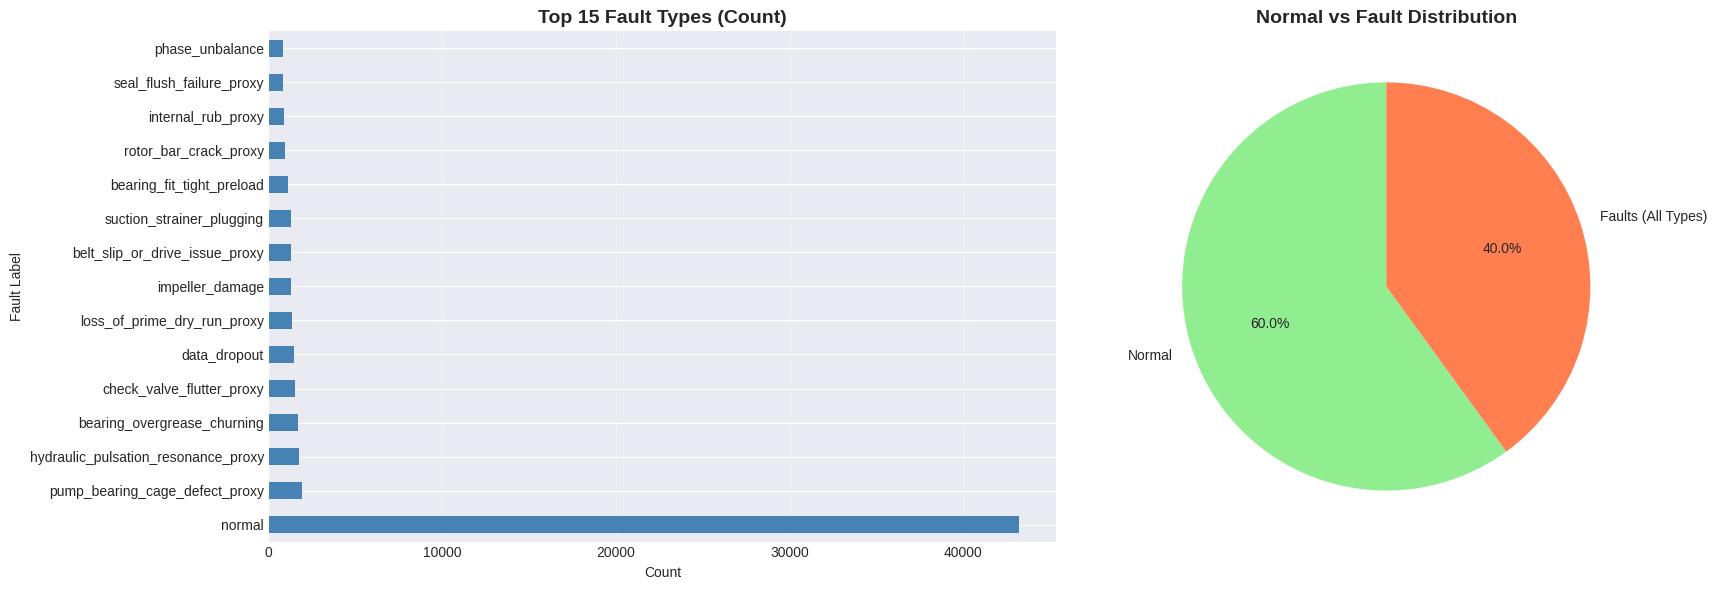


✅ Normal operation: 43,201 (60.0%)
⚠️  Fault conditions: 28,799 (40.0%)


In [ ]:
# Analyze fault distribution
print("="*80)
print("🚨 FAULT LABEL DISTRIBUTION")
print("="*80)

fault_counts = df['fault_label'].value_counts()
fault_percentages = df['fault_label'].value_counts(normalize=True) * 100

fault_stats = pd.DataFrame({
    'Count': fault_counts,
    'Percentage': fault_percentages
})

print(f"\n📊 Total Unique Faults: {df['fault_label'].nunique()}")
print(f"\n{fault_stats}")

# Visualize fault distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 15 faults
fault_counts.head(15).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Top 15 Fault Types (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Fault Label')
axes[0].grid(axis='x', alpha=0.3)

# Pie chart for normal vs faults
normal_count = fault_counts['normal']
fault_count = len(df) - normal_count
axes[1].pie([normal_count, fault_count],
            labels=['Normal', 'Faults (All Types)'],
            autopct='%1.1f%%',
            colors=['lightgreen', 'coral'],
            startangle=90)
axes[1].set_title('Normal vs Fault Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Normal operation: {normal_count:,} ({normal_count/len(df)*100:.1f}%)")
print(f"⚠️  Fault conditions: {fault_count:,} ({fault_count/len(df)*100:.1f}%)")

## 4️⃣ Fault Definitions

Below is the complete list of fault types and their descriptions.

In [ ]:
# Fault definitions dictionary
fault_definitions = {
    'normal': 'Healthy baseline (no injected fault)',
    'electrical_fluting': 'Electrical fluting / EDM pitting proxy (persistent HF + ultrasound)',
    'phase_unbalance': 'Phase voltage/current unbalance (torque ripple + heating)',
    'cooling_failure': 'Motor cooling failure (rapid temperature rise)',
    'rotor_bar_crack_proxy': 'Rotor bar crack proxy (load-dependent torque ripple + heating)',
    'coupling_wear': 'Coupling element wear/degradation',
    'loose_hub_keyway': 'Loose hub/keyway fretting (impacts + broadband)',
    'shaft_bow_proxy': 'Shaft bow / thermal bow proxy (time-varying unbalance)',
    'piping_strain': 'Piping strain / nozzle loads (misalignment-like)',
    'foundation_grout_degradation': 'Foundation/grout degradation (stiffness loss / amplification)',
    'air_gas_ingress': 'Air/gas ingress (two-phase, erratic HF)',
    'suction_strainer_plugging': 'Suction strainer plugging/restriction (operating point shift, HF rise)',
    'discharge_restriction': 'Discharge restriction / throttling (off-BEP instability)',
    'impeller_damage': 'Impeller damage/erosion (unbalance + hydraulic disturbance)',
    'wear_ring_clearance': 'Wear ring clearance increase (subtle efficiency/instability)',
    'seal_face_distress_proxy': 'Seal face distress proxy (HF + temperature)',
    'internal_rub_proxy': 'Internal rub proxy (broadband + temperature + ultrasound spikes)',
    'pump_bearing_cage_defect_proxy': 'Pump bearing cage defect proxy (erratic HF)',
    'fan_blade_damage': 'Fan blade damage (unbalance + aero disturbance)',
    'blower_aero_stall_surge_proxy': 'Blower aerodynamic stall/surge proxy (high variability)',
    'belt_slip_or_drive_issue_proxy': 'Belt slip/drive issue proxy (speed/load fluctuation)',
    'sensor_drift_bias': 'Sensor drift/bias (data quality fault)',
    'data_dropout': 'Data dropout (missing samples / comms issue)',
    'bearing_overgrease_churning': 'Bearing over-greasing / churning (HF + ultrasound + temperature rise)',
    'lube_contamination_water_particles': 'Lubricant contamination (water/particles) accelerating wear (HF + ultrasound + mild temp rise)',
    'bearing_fit_loose_housing': 'Loose bearing fit/housing fretting (broadband + impacts + ultrasound spikes)',
    'bearing_fit_tight_preload': 'Tight bearing fit / excessive preload (temperature + HF rise)',
    'loss_of_prime_dry_run_proxy': 'Loss of prime / dry-run proxy (strong HF + ultrasound spikes + temp rise + variability)',
    'check_valve_flutter_proxy': 'Check valve flutter proxy (hydraulic pulsation, high variability, mid/high band rise)',
    'hydraulic_pulsation_resonance_proxy': 'Hydraulic pulsation / resonance proxy (mid-band rise + variability)',
    'seal_flush_failure_proxy': 'Seal flush failure proxy (seal distress → temp + ultrasound + high band rise)',
    'power_frequency_variation_proxy': 'Power frequency variation proxy (speed-related variability in low/mid bands)',
    'instrument_scaling_error': 'Instrumentation scaling error (one channel scaled incorrectly)',
    'stuck_sensor_flatline': 'Stuck sensor / flatline (one channel stuck at constant value)'
}

# Display fault definitions
print("="*80)
print("🔧 FAULT DEFINITIONS")
print("="*80)
for i, (fault, description) in enumerate(fault_definitions.items(), 1):
    print(f"\n{i:2d}. {fault}")
    print(f"    └─ {description}")

# Save to JSON for future reference
with open('fault_definitions.json', 'w') as f:
    json.dump(fault_definitions, f, indent=2)
print("\n✅ Fault definitions saved to 'fault_definitions.json'")

🔧 FAULT DEFINITIONS

 1. normal
    └─ Healthy baseline (no injected fault)

 2. electrical_fluting
    └─ Electrical fluting / EDM pitting proxy (persistent HF + ultrasound)

 3. phase_unbalance
    └─ Phase voltage/current unbalance (torque ripple + heating)

 4. cooling_failure
    └─ Motor cooling failure (rapid temperature rise)

 5. rotor_bar_crack_proxy
    └─ Rotor bar crack proxy (load-dependent torque ripple + heating)

 6. coupling_wear
    └─ Coupling element wear/degradation

 7. loose_hub_keyway
    └─ Loose hub/keyway fretting (impacts + broadband)

 8. shaft_bow_proxy
    └─ Shaft bow / thermal bow proxy (time-varying unbalance)

 9. piping_strain
    └─ Piping strain / nozzle loads (misalignment-like)

10. foundation_grout_degradation
    └─ Foundation/grout degradation (stiffness loss / amplification)

11. air_gas_ingress
    └─ Air/gas ingress (two-phase, erratic HF)

12. suction_strainer_plugging
    └─ Suction strainer plugging/restriction (operating point shift, H

## 5️⃣ Data Preprocessing

### 5.1 Handle Missing Values and Prepare Features

In [ ]:
# Create a copy for preprocessing
df_processed = df.copy()

# Convert timestamp to datetime
df_processed['timestamp'] = pd.to_datetime(df_processed['timestamp'])

# Sort by timestamp to ensure temporal order
df_processed = df_processed.sort_values('timestamp').reset_index(drop=True)

# Handle missing values (forward fill then backward fill)
print(f"Missing values before: {df_processed.isnull().sum().sum()}")
df_processed = df_processed.fillna(method='ffill').fillna(method='bfill')
print(f"Missing values after: {df_processed.isnull().sum().sum()}")

# Extract sensor features (exclude timestamp, state, regime, fault_label)
sensor_columns = [col for col in df_processed.columns
                  if col not in ['timestamp', 'state', 'regime', 'fault_label']]

print(f"\n📊 Sensor features: {len(sensor_columns)}")
print("Sensors:", sensor_columns)

# Display preprocessed data info
print(f"\n✅ Preprocessed dataset shape: {df_processed.shape}")
print(f"Date range: {df_processed['timestamp'].min()} to {df_processed['timestamp'].max()}")
df_processed.head()

Missing values before: 2604
Missing values after: 0

📊 Sensor features: 24
Sensors: ['motor_DE_vib_band_1', 'motor_DE_vib_band_2', 'motor_DE_vib_band_3', 'motor_DE_vib_band_4', 'motor_DE_ultra_db', 'motor_DE_temp_c', 'motor_NDE_vib_band_1', 'motor_NDE_vib_band_2', 'motor_NDE_vib_band_3', 'motor_NDE_vib_band_4', 'motor_NDE_ultra_db', 'motor_NDE_temp_c', 'pump_DE_vib_band_1', 'pump_DE_vib_band_2', 'pump_DE_vib_band_3', 'pump_DE_vib_band_4', 'pump_DE_ultra_db', 'pump_DE_temp_c', 'pump_NDE_vib_band_1', 'pump_NDE_vib_band_2', 'pump_NDE_vib_band_3', 'pump_NDE_vib_band_4', 'pump_NDE_ultra_db', 'pump_NDE_temp_c']

✅ Preprocessed dataset shape: (72000, 28)
Date range: 2025-12-25 12:01:00 to 2026-01-24 12:00:00


,timestamp,state,regime,motor_DE_vib_band_1,motor_DE_vib_band_2,motor_DE_vib_band_3,motor_DE_vib_band_4,motor_DE_ultra_db,motor_DE_temp_c,motor_NDE_vib_band_1,...,pump_DE_vib_band_4,pump_DE_ultra_db,pump_DE_temp_c,pump_NDE_vib_band_1,pump_NDE_vib_band_2,pump_NDE_vib_band_3,pump_NDE_vib_band_4,pump_NDE_ultra_db,pump_NDE_temp_c,fault_label
0,2025-12-25 12:01:00,fault_injections,nominal,1.272041,1.028084,0.805969,0.689601,34.071822,44.965710,1.320385,...,0.818946,39.403464,42.067911,1.289210,1.044604,0.740187,0.761924,38.917583,42.040019,normal
1,2025-12-25 12:02:00,fault_injections,nominal,1.267974,1.007397,0.874207,0.649305,34.093649,44.982014,1.193305,...,0.790250,38.822071,42.000157,1.261384,1.009261,0.844916,0.769346,38.868199,41.885573,normal
2,2025-12-25 12:03:00,fault_injections,nominal,1.214692,1.107286,0.871198,0.666770,34.256218,44.936660,1.249795,...,0.740222,38.792586,42.015186,1.252384,1.081312,0.872658,0.772152,38.963265,41.848892,normal
3,2025-12-25 12:04:00,fault_injections,nominal,1.173619,1.043607,0.895361,0.683752,33.839200,45.211979,1.245771,...,0.739490,39.146580,41.919477,1.326698,1.067701,0.834470,0.707249,38.715864,41.962250,normal
4,2025-12-25 12:05:00,fault_injections,nominal,1.249433,1.002476,0.823933,0.619318,33.494938,44.989684,1.247678,...,0.790806,39.174106,42.012268,1.275505,0.997710,0.870404,0.743798,39.128174,41.865456,normal


### 5.2 Create Sliding Window Features

This is the **key component** for time-series anomaly detection. We'll create windows of sequential readings and extract statistical features from each window.

In [ ]:
# Window configuration
WINDOW_SIZE = 10  # Number of time steps in each window (adjust based on your needs)
STEP_SIZE = 5      # Step size for sliding window (smaller = more overlap, more samples)

print(f"⚙️ Window Configuration:")
print(f"  • Window size: {WINDOW_SIZE} time steps")
print(f"  • Step size: {STEP_SIZE} time steps")
print(f"  • Overlap: {WINDOW_SIZE - STEP_SIZE} time steps")
print(f"\n📝 Note: Each window represents {WINDOW_SIZE} minutes of continuous sensor data")

⚙️ Window Configuration:
  • Window size: 10 time steps
  • Step size: 5 time steps
  • Overlap: 5 time steps

📝 Note: Each window represents 10 minutes of continuous sensor data


In [ ]:
def create_window_features(df, sensor_cols, window_size, step_size):
    """
    Create sliding window features from time series data.

    For each window, we extract:
    - Mean, Std, Min, Max, Range
    - Median, Q25, Q75, IQR
    - Skewness, Kurtosis
    - First value, Last value, Trend (last - first)

    Args:
        df: DataFrame with sensor data
        sensor_cols: List of sensor column names
        window_size: Number of time steps in each window
        step_size: Step size for sliding window

    Returns:
        X: Feature matrix (windows × features)
        y: Target labels (one per window)
        window_indices: List of (start, end) indices for each window
    """
    from scipy import stats

    features_list = []
    labels_list = []
    window_indices = []

    # Calculate number of windows
    n_windows = (len(df) - window_size) // step_size + 1

    print(f"Creating {n_windows:,} windows...")

    for i in tqdm(range(0, len(df) - window_size + 1, step_size)):
        window = df.iloc[i:i+window_size]

        # Get the majority label in the window (mode)
        label = window['fault_label'].mode()[0]

        # Extract features for each sensor
        window_features = []

        for col in sensor_cols:
            values = window[col].values

            # Statistical features
            window_features.extend([
                np.mean(values),           # Mean
                np.std(values),            # Standard deviation
                np.min(values),            # Minimum
                np.max(values),            # Maximum
                np.max(values) - np.min(values),  # Range
                np.median(values),         # Median
                np.percentile(values, 25), # Q1
                np.percentile(values, 75), # Q3
                np.percentile(values, 75) - np.percentile(values, 25),  # IQR
                stats.skew(values),        # Skewness
                stats.kurtosis(values),    # Kurtosis
                values[0],                 # First value
                values[-1],                # Last value
                values[-1] - values[0],    # Trend (change)
            ])

        features_list.append(window_features)
        labels_list.append(label)
        window_indices.append((i, i+window_size))

    X = np.array(features_list)
    y = np.array(labels_list)

    print(f"\n✅ Window features created!")
    print(f"  • Feature matrix shape: {X.shape}")
    print(f"  • Labels shape: {y.shape}")
    print(f"  • Features per sensor: 14")
    print(f"  • Total features: {X.shape[1]} (24 sensors × 14 features/sensor)")

    return X, y, window_indices

# Create window features
X, y, window_indices = create_window_features(
    df_processed,
    sensor_columns,
    WINDOW_SIZE,
    STEP_SIZE
)

Creating 14,399 windows...


  0%|          | 0/14399 [00:00<?, ?it/s]


✅ Window features created!
  • Feature matrix shape: (14399, 336)
  • Labels shape: (14399,)
  • Features per sensor: 14
  • Total features: 336 (24 sensors × 14 features/sensor)


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\n🏷️ Label Encoding:")
print(f"  • Number of classes: {len(label_encoder.classes_)}")
print(f"  • Encoded labels range: {y_encoded.min()} to {y_encoded.max()}")
print(f"\n📋 Class mapping:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y_encoded == i)
    print(f"  {i:2d} -> {label:40s} (n={count:,})")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("\n✅ Label encoder saved to 'label_encoder.pkl'")


🏷️ Label Encoding:
  • Number of classes: 34
  • Encoded labels range: 0 to 33

📋 Class mapping:
   0 -> air_gas_ingress                          (n=131)
   1 -> bearing_fit_loose_housing                (n=174)
   2 -> bearing_fit_tight_preload                (n=363)
   3 -> bearing_overgrease_churning              (n=617)
   4 -> belt_slip_or_drive_issue_proxy           (n=426)
   5 -> blower_aero_stall_surge_proxy            (n=107)
   6 -> check_valve_flutter_proxy                (n=471)
   7 -> cooling_failure                          (n=147)
   8 -> coupling_wear                            (n=157)
   9 -> data_dropout                             (n=393)
  10 -> discharge_restriction                    (n=192)
  11 -> electrical_fluting                       (n=81)
  12 -> fan_blade_damage                         (n=191)
  13 -> foundation_grout_degradation             (n=129)
  14 -> hydraulic_pulsation_resonance_proxy      (n=503)
  15 -> impeller_damage                         

## 6️⃣ Train-Test Split and Feature Scaling

In [ ]:
# Encode labels (added from previous cell to resolve NameError)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_encoded
)

print(f"📊 Data Split:")
print(f"  • Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f} %)")
print(f"  • Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f} %)")
print(f"  • Features: {X_train.shape[1]}")

# Feature scaling using RobustScaler (robust to outliers)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Feature scaling completed (RobustScaler)")
print(f"  • Robust to outliers in sensor data")

# Save scaler
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("  • Scaler saved to 'feature_scaler.pkl'")

# Display class distribution in train/test
print(f"\n📊 Class Distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
test_dist = pd.Series(y_test).value_counts().sort_index()

dist_df = pd.DataFrame({
    'Train': train_dist,
    'Test': test_dist,
    'Total': train_dist + test_dist
})
dist_df.index = [label_encoder.classes_[i] for i in dist_df.index]
print(dist_df.head(10))

📊 Data Split:
  • Training set: 11,519 samples (80.0 %)
  • Test set: 2,880 samples (20.0 %)
  • Features: 336

✅ Feature scaling completed (RobustScaler)
  • Robust to outliers in sensor data
  • Scaler saved to 'feature_scaler.pkl'

📊 Class Distribution:
                                Train  Test  Total
air_gas_ingress                   105    26    131
bearing_fit_loose_housing         139    35    174
bearing_fit_tight_preload         290    73    363
bearing_overgrease_churning       494   123    617
belt_slip_or_drive_issue_proxy    341    85    426
blower_aero_stall_surge_proxy      86    21    107
check_valve_flutter_proxy         377    94    471
cooling_failure                   118    29    147
coupling_wear                     126    31    157
data_dropout                      314    79    393


### 6.1 Calculate Class Weights

To handle class imbalance, we'll compute weights for each class.

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create sample weights for training
sample_weights = np.array([class_weights[y] for y in y_train])

print(f"⚖️ Class Weights (for imbalanced data):")
for i, weight in enumerate(class_weights):
    label = label_encoder.classes_[i]
    count = np.sum(y_train == i)
    print(f"  {label:40s} -> weight: {weight:6.3f} (n={count:,})")

print(f"\n✅ Sample weights created for training")
print(f"  • Weights range: {sample_weights.min():.3f} to {sample_weights.max():.3f}")

⚖️ Class Weights (for imbalanced data):
  air_gas_ingress                          -> weight:  3.227 (n=105)
  bearing_fit_loose_housing                -> weight:  2.437 (n=139)
  bearing_fit_tight_preload                -> weight:  1.168 (n=290)
  bearing_overgrease_churning              -> weight:  0.686 (n=494)
  belt_slip_or_drive_issue_proxy           -> weight:  0.994 (n=341)
  blower_aero_stall_surge_proxy            -> weight:  3.939 (n=86)
  check_valve_flutter_proxy                -> weight:  0.899 (n=377)
  cooling_failure                          -> weight:  2.871 (n=118)
  coupling_wear                            -> weight:  2.689 (n=126)
  data_dropout                             -> weight:  1.079 (n=314)
  discharge_restriction                    -> weight:  2.200 (n=154)
  electrical_fluting                       -> weight:  5.212 (n=65)
  fan_blade_damage                         -> weight:  2.214 (n=153)
  foundation_grout_degradation             -> weight:  3.289 (n=1

## 7️⃣ Model Training with XGBoost

### 7.1 Configure XGBoost Parameters

In [ ]:
# XGBoost parameters optimized for multi-class classification
xgb_params = {
    'objective': 'multi:softprob',  # Multi-class classification with probabilities
    'num_class': len(label_encoder.classes_),  # Number of fault types
    'max_depth': 8,                 # Maximum tree depth
    'learning_rate': 0.1,           # Step size shrinkage
    'n_estimators': 300,            # Number of boosting rounds
    'subsample': 0.8,               # Subsample ratio of training instances
    'colsample_bytree': 0.8,        # Subsample ratio of columns when constructing each tree
    'min_child_weight': 3,          # Minimum sum of instance weight needed in a child
    'gamma': 0.1,                   # Minimum loss reduction for split
    'reg_alpha': 0.1,               # L1 regularization
    'reg_lambda': 1.0,              # L2 regularization
    'random_state': RANDOM_SEED,
    'n_jobs': -1,                   # Use all CPU cores
    'tree_method': 'hist',          # Faster histogram-based algorithm
    'eval_metric': 'mlogloss',      # Multi-class log loss
    'early_stopping_rounds': 50,    # Stop if no improvement
    'verbosity': 1
}

print("🎯 XGBoost Configuration:")
for key, value in xgb_params.items():
    print(f"  • {key:25s}: {value}")

🎯 XGBoost Configuration:
  • objective                : multi:softprob
  • num_class                : 34
  • max_depth                : 8
  • learning_rate            : 0.1
  • n_estimators             : 300
  • subsample                : 0.8
  • colsample_bytree         : 0.8
  • min_child_weight         : 3
  • gamma                    : 0.1
  • reg_alpha                : 0.1
  • reg_lambda               : 1.0
  • random_state             : 42
  • n_jobs                   : -1
  • tree_method              : hist
  • eval_metric              : mlogloss
  • early_stopping_rounds    : 50
  • verbosity                : 1


### 7.2 Train the Model

### 7.2 K-Fold Cross Validation

We'll use **K-Fold Cross Validation** to get a robust estimate of model performance and reduce overfitting.

In [ ]:
print("🔄 Performing K-Fold Cross Validation...\n")
print("="*80)

# Setup K-Fold Cross Validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

# Store metrics for each fold
fold_metrics = {
    'accuracy': [],
    'balanced_accuracy': [],
    'f1_weighted': [],
    'train_accuracy': [],
    'train_balanced_accuracy': []
}

fold_models = []

# Perform K-Fold Cross Validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded), 1):
    print(f"\n📊 Fold {fold}/{n_splits}")
    print("-" * 80)
    
    # Split data
    X_fold_train, X_fold_val = X[train_idx], X[val_idx]
    y_fold_train, y_fold_val = y_encoded[train_idx], y_encoded[val_idx]
    
    # Scale features
    fold_scaler = RobustScaler()
    X_fold_train_scaled = fold_scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = fold_scaler.transform(X_fold_val)
    
    # Calculate sample weights for this fold
    fold_class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_fold_train),
        y=y_fold_train
    )
    fold_sample_weights = np.array([fold_class_weights[y] for y in y_fold_train])
    
    # Train model for this fold
    fold_model = xgb.XGBClassifier(**xgb_params)
    fold_model.fit(
        X_fold_train_scaled,
        y_fold_train,
        sample_weight=fold_sample_weights,
        eval_set=[(X_fold_train_scaled, y_fold_train), (X_fold_val_scaled, y_fold_val)],
        verbose=False
    )
    
    # Make predictions
    y_fold_train_pred = fold_model.predict(X_fold_train_scaled)
    y_fold_val_pred = fold_model.predict(X_fold_val_scaled)
    
    # Calculate metrics
    train_acc = accuracy_score(y_fold_train, y_fold_train_pred)
    val_acc = accuracy_score(y_fold_val, y_fold_val_pred)
    train_bal_acc = balanced_accuracy_score(y_fold_train, y_fold_train_pred)
    val_bal_acc = balanced_accuracy_score(y_fold_val, y_fold_val_pred)
    val_f1 = f1_score(y_fold_val, y_fold_val_pred, average='weighted')
    
    # Store metrics
    fold_metrics['train_accuracy'].append(train_acc)
    fold_metrics['train_balanced_accuracy'].append(train_bal_acc)
    fold_metrics['accuracy'].append(val_acc)
    fold_metrics['balanced_accuracy'].append(val_bal_acc)
    fold_metrics['f1_weighted'].append(val_f1)
    fold_models.append(fold_model)
    
    # Print fold results
    print(f"  Training Accuracy:          {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Training Balanced Accuracy: {train_bal_acc:.4f} ({train_bal_acc*100:.2f}%)")
    print(f"  Validation Accuracy:        {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"  Validation Balanced Accuracy: {val_bal_acc:.4f} ({val_bal_acc*100:.2f}%)")
    print(f"  Validation F1 Score:        {val_f1:.4f}")
    print(f"  Gap (Train-Val Accuracy):   {(train_acc - val_acc):.4f}")

print("\n" + "="*80)
print("📈 K-FOLD CROSS VALIDATION RESULTS")
print("="*80)

# Calculate mean and std for each metric
print("\n🎯 Validation Metrics (Mean ± Std):")
print(f"  Accuracy:          {np.mean(fold_metrics['accuracy']):.4f} ± {np.std(fold_metrics['accuracy']):.4f}")
print(f"  Balanced Accuracy: {np.mean(fold_metrics['balanced_accuracy']):.4f} ± {np.std(fold_metrics['balanced_accuracy']):.4f}")
print(f"  F1 Score:          {np.mean(fold_metrics['f1_weighted']):.4f} ± {np.std(fold_metrics['f1_weighted']):.4f}")

print("\n📊 Training Metrics (Mean ± Std):")
print(f"  Accuracy:          {np.mean(fold_metrics['train_accuracy']):.4f} ± {np.std(fold_metrics['train_accuracy']):.4f}")
print(f"  Balanced Accuracy: {np.mean(fold_metrics['train_balanced_accuracy']):.4f} ± {np.std(fold_metrics['train_balanced_accuracy']):.4f}")

print("\n🔍 Overfitting Analysis:")
train_val_gap = np.mean(fold_metrics['train_accuracy']) - np.mean(fold_metrics['accuracy'])
print(f"  Average Gap (Train-Val):   {train_val_gap:.4f}")
if train_val_gap < 0.05:
    print("  ✅ Low overfitting - Model generalizes well!")
elif train_val_gap < 0.10:
    print("  ⚠️  Moderate overfitting - Consider regularization")
else:
    print("  ❌ High overfitting - Needs improvement")

print("\n💡 Cross-validation helps ensure robust performance estimates!")

In [ ]:
# Visualize K-Fold Cross Validation Results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('K-Fold Cross Validation Performance', fontsize=16, fontweight='bold')

# 1. Accuracy across folds
folds = list(range(1, n_splits + 1))
axes[0, 0].plot(folds, fold_metrics['train_accuracy'], 'o-', label='Training', linewidth=2, markersize=8)
axes[0, 0].plot(folds, fold_metrics['accuracy'], 's-', label='Validation', linewidth=2, markersize=8)
axes[0, 0].axhline(np.mean(fold_metrics['accuracy']), color='red', linestyle='--', 
                   label=f'Mean Val: {np.mean(fold_metrics["accuracy"]):.4f}')
axes[0, 0].fill_between(folds, 
                        np.mean(fold_metrics['accuracy']) - np.std(fold_metrics['accuracy']),
                        np.mean(fold_metrics['accuracy']) + np.std(fold_metrics['accuracy']),
                        alpha=0.2, color='red')
axes[0, 0].set_xlabel('Fold', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('Accuracy Across Folds', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(folds)

# 2. Balanced Accuracy across folds
axes[0, 1].plot(folds, fold_metrics['train_balanced_accuracy'], 'o-', label='Training', linewidth=2, markersize=8)
axes[0, 1].plot(folds, fold_metrics['balanced_accuracy'], 's-', label='Validation', linewidth=2, markersize=8)
axes[0, 1].axhline(np.mean(fold_metrics['balanced_accuracy']), color='red', linestyle='--',
                   label=f'Mean Val: {np.mean(fold_metrics["balanced_accuracy"]):.4f}')
axes[0, 1].fill_between(folds,
                        np.mean(fold_metrics['balanced_accuracy']) - np.std(fold_metrics['balanced_accuracy']),
                        np.mean(fold_metrics['balanced_accuracy']) + np.std(fold_metrics['balanced_accuracy']),
                        alpha=0.2, color='red')
axes[0, 1].set_xlabel('Fold', fontsize=12)
axes[0, 1].set_ylabel('Balanced Accuracy', fontsize=12)
axes[0, 1].set_title('Balanced Accuracy Across Folds', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(folds)

# 3. F1 Score across folds
axes[1, 0].plot(folds, fold_metrics['f1_weighted'], 'd-', label='Validation F1', linewidth=2, markersize=8, color='green')
axes[1, 0].axhline(np.mean(fold_metrics['f1_weighted']), color='darkgreen', linestyle='--',
                   label=f'Mean: {np.mean(fold_metrics["f1_weighted"]):.4f}')
axes[1, 0].fill_between(folds,
                        np.mean(fold_metrics['f1_weighted']) - np.std(fold_metrics['f1_weighted']),
                        np.mean(fold_metrics['f1_weighted']) + np.std(fold_metrics['f1_weighted']),
                        alpha=0.2, color='green')
axes[1, 0].set_xlabel('Fold', fontsize=12)
axes[1, 0].set_ylabel('F1 Score (Weighted)', fontsize=12)
axes[1, 0].set_title('F1 Score Across Folds', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(folds)

# 4. Train-Validation Gap (Overfitting indicator)
gaps = [train - val for train, val in zip(fold_metrics['train_accuracy'], fold_metrics['accuracy'])]
colors = ['green' if gap < 0.05 else 'orange' if gap < 0.10 else 'red' for gap in gaps]
axes[1, 1].bar(folds, gaps, color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].axhline(0.05, color='orange', linestyle='--', label='Moderate threshold (5%)', linewidth=1.5)
axes[1, 1].axhline(0.10, color='red', linestyle='--', label='High threshold (10%)', linewidth=1.5)
axes[1, 1].axhline(np.mean(gaps), color='blue', linestyle='-', label=f'Mean Gap: {np.mean(gaps):.4f}', linewidth=2)
axes[1, 1].set_xlabel('Fold', fontsize=12)
axes[1, 1].set_ylabel('Train-Val Gap', fontsize=12)
axes[1, 1].set_title('Overfitting Analysis (Train-Val Accuracy Gap)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticks(folds)

plt.tight_layout()
plt.savefig('kfold_cv_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Visualization saved as 'kfold_cv_performance.png'")

### 7.3 Train Final Model on Full Dataset

After K-Fold validation, we train a final model on the entire training set for deployment.

In [ ]:
print("\n" + "="*80)
print("🚀 Training Final Model on Full Dataset...")
print("="*80)

# Use train_test_split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_encoded
)

# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for deployment
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Calculate sample weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
sample_weights = np.array([class_weights[y] for y in y_train])

# Train final model
model = xgb.XGBClassifier(**xgb_params)
model.fit(
    X_train_scaled,
    y_train,
    sample_weight=sample_weights,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# Save the final model
model.save_model('xgboost_anomaly_detector.json')

print("\n✅ Final model training completed!")
print("💾 Model saved to 'xgboost_anomaly_detector.json'")
print("💾 Scaler saved to 'feature_scaler.pkl'")

# Quick evaluation on test set
y_pred_test = model.predict(X_test_scaled)
final_test_acc = accuracy_score(y_test, y_pred_test)
final_test_bal_acc = balanced_accuracy_score(y_test, y_pred_test)

print(f"\n📊 Final Model Test Performance:")
print(f"  Test Accuracy:          {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
print(f"  Test Balanced Accuracy: {final_test_bal_acc:.4f} ({final_test_bal_acc*100:.2f}%)")

## 8️⃣ Model Evaluation

In [ ]:
# Make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Prediction probabilities
y_pred_proba_train = model.predict_proba(X_train_scaled)
y_pred_proba_test = model.predict_proba(X_test_scaled)

print("="*80)
print("📊 MODEL PERFORMANCE METRICS")
print("="*80)

# Accuracy
train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"\n🎯 Accuracy:")
print(f"  • Training: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  • Test: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Balanced accuracy (accounts for class imbalance)
train_bal_acc = balanced_accuracy_score(y_train, y_pred_train)
test_bal_acc = balanced_accuracy_score(y_test, y_pred_test)

print(f"\n⚖️ Balanced Accuracy:")
print(f"  • Training: {train_bal_acc:.4f} ({train_bal_acc*100:.2f}%)")
print(f"  • Test: {test_bal_acc:.4f} ({test_bal_acc*100:.2f}%)")

# Weighted F1 score
train_f1 = f1_score(y_train, y_pred_train, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"\n📈 Weighted F1 Score:")
print(f"  • Training: {train_f1:.4f}")
print(f"  • Test: {test_f1:.4f}")

# Top-K accuracy
top3_train = top_k_accuracy_score(y_train, y_pred_proba_train, k=3)
top3_test = top_k_accuracy_score(y_test, y_pred_proba_test, k=3)

print(f"\n🏆 Top-3 Accuracy:")
print(f"  • Training: {top3_train:.4f} ({top3_train*100:.2f}%)")
print(f"  • Test: {top3_test:.4f} ({top3_test*100:.2f}%)")

print(f"\n💡 Top-3 means the correct fault is in the model's top 3 predictions")

📊 MODEL PERFORMANCE METRICS

🎯 Accuracy:
  • Training: 0.9937 (99.37%)
  • Test: 0.9306 (93.06%)

⚖️ Balanced Accuracy:
  • Training: 0.9997 (99.97%)
  • Test: 0.8766 (87.66%)

📈 Weighted F1 Score:
  • Training: 0.9938
  • Test: 0.9212

🏆 Top-3 Accuracy:
  • Training: 1.0000 (100.00%)
  • Test: 0.9941 (99.41%)

💡 Top-3 means the correct fault is in the model's top 3 predictions


### 8.1 Detailed Classification Report

In [ ]:
# Classification report
print("="*80)
print("📋 CLASSIFICATION REPORT (TEST SET)")
print("="*80)
print()

report = classification_report(
    y_test,
    y_pred_test,
    target_names=label_encoder.classes_,
    digits=3
)
print(report)

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test,
    y_pred_test,
    average=None
)

# Create detailed metrics DataFrame
metrics_df = pd.DataFrame({
    'Fault': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Sort by F1 score
metrics_df = metrics_df.sort_values('F1-Score', ascending=False)

print("\n📊 Per-Class Metrics (sorted by F1-Score):")
print(metrics_df.to_string(index=False))

# Identify problematic classes
print("\n⚠️ Classes with F1-Score < 0.7:")
problematic = metrics_df[metrics_df['F1-Score'] < 0.7]
if len(problematic) > 0:
    print(problematic.to_string(index=False))
else:
    print("  None! All classes perform well.")

📋 CLASSIFICATION REPORT (TEST SET)

                                     precision    recall  f1-score   support

                    air_gas_ingress      0.963     1.000     0.981        26
          bearing_fit_loose_housing      1.000     1.000     1.000        35
          bearing_fit_tight_preload      1.000     0.986     0.993        73
        bearing_overgrease_churning      0.992     1.000     0.996       123
     belt_slip_or_drive_issue_proxy      0.783     0.976     0.869        85
      blower_aero_stall_surge_proxy      0.875     1.000     0.933        21
          check_valve_flutter_proxy      0.905     0.915     0.910        94
                    cooling_failure      0.966     0.966     0.966        29
                      coupling_wear      0.871     0.871     0.871        31
                       data_dropout      0.714     0.127     0.215        79
              discharge_restriction      0.971     0.868     0.917        38
                 electrical_fluting    

### 8.2 Confusion Matrix Visualization

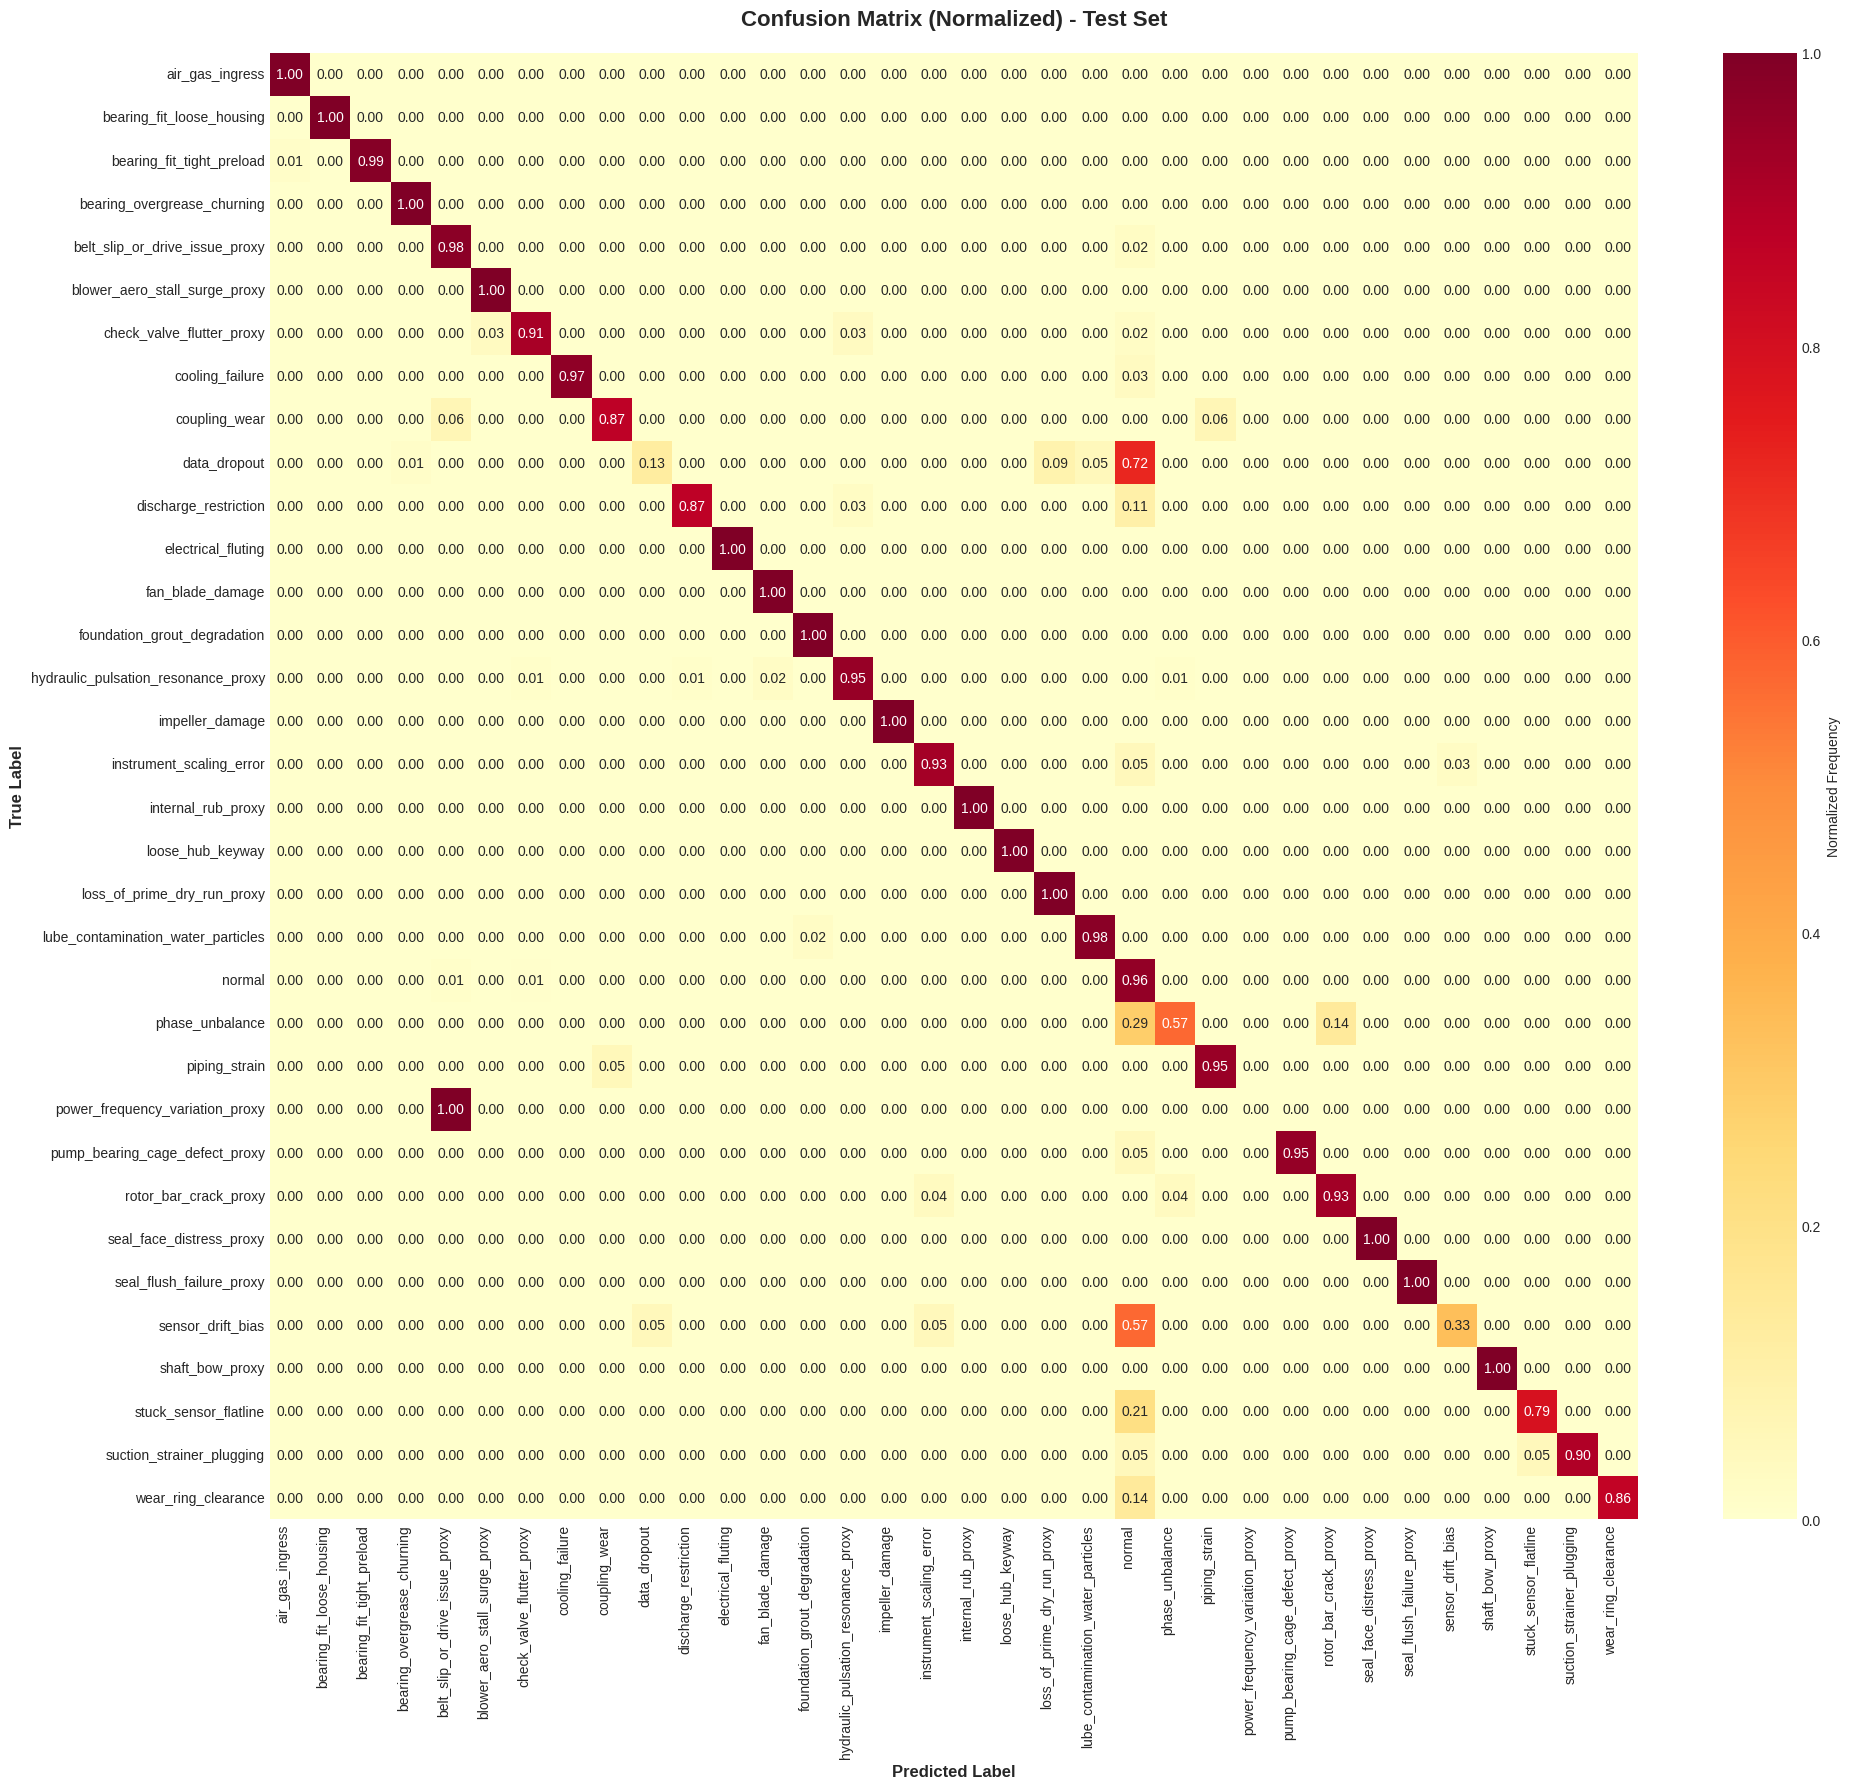


💡 Interpretation:
  • Diagonal cells = correct predictions
  • Off-diagonal cells = misclassifications
  • Darker colors indicate higher values


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(20, 18))

sns.heatmap(
    cm_normalized,
    annot=True,  # Too many classes for annotations
    fmt='.2f',
    cmap='YlOrRd',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Normalized Frequency'},
    ax=ax
)

ax.set_title('Confusion Matrix (Normalized) - Test Set', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')

plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("  • Diagonal cells = correct predictions")
print("  • Off-diagonal cells = misclassifications")
print("  • Darker colors indicate higher values")

### 8.3 Feature Importance Analysis

🎯 TOP 30 MOST IMPORTANT FEATURES
                    Feature  Importance
     pump_DE_vib_band_4_iqr    0.029937
     pump_DE_vib_band_4_q25    0.028216
   motor_NDE_vib_band_3_std    0.026630
    motor_DE_vib_band_3_iqr    0.019929
motor_NDE_vib_band_4_median    0.013708
 pump_NDE_vib_band_4_median    0.012926
   motor_NDE_vib_band_3_q25    0.012367
   motor_NDE_vib_band_2_std    0.012197
      pump_NDE_ultra_db_iqr    0.011223
     pump_DE_vib_band_2_q75    0.010993
     pump_DE_vib_band_1_q75    0.010852
    pump_NDE_vib_band_2_q25    0.010681
       pump_DE_ultra_db_q75    0.010621
         pump_DE_temp_c_max    0.010143
    motor_DE_vib_band_4_q75    0.010108
     motor_NDE_ultra_db_iqr    0.010065
     pump_DE_vib_band_4_max    0.009857
 motor_DE_vib_band_4_median    0.009831
        motor_DE_temp_c_std    0.009497
   motor_DE_vib_band_2_mean    0.009410
   motor_NDE_vib_band_3_q75    0.009394
   motor_NDE_vib_band_1_std    0.009112
  pump_DE_vib_band_4_median    0.008988
       

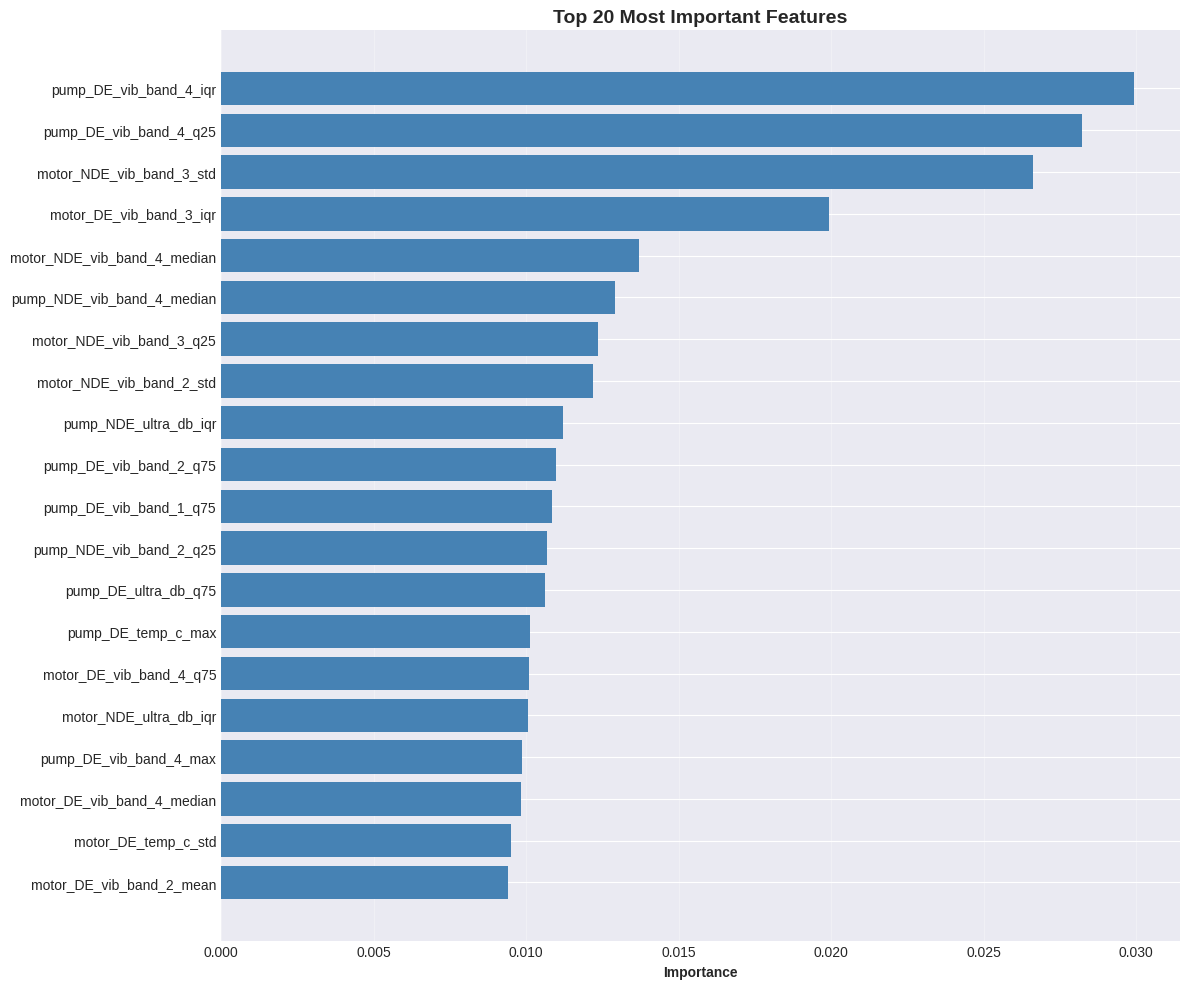


📊 Importance by Sensor (aggregated):
Sensor
pump_DE_vib_band_4      0.094971
motor_NDE_vib_band_3    0.058894
motor_NDE_vib_band_1    0.052435
motor_DE_vib_band_3     0.051880
pump_DE_ultra_db        0.047981
pump_DE_vib_band_1      0.047854
motor_DE_vib_band_4     0.046636
motor_DE_temp_c         0.043590
pump_NDE_ultra_db       0.043534
pump_NDE_vib_band_2     0.043463
Name: Importance, dtype: float32

📊 Importance by Statistic (aggregated):
Statistic
iqr       0.138353
q75       0.132785
std       0.122682
max       0.114523
mean      0.114212
median    0.113104
q25       0.089712
last      0.042823
range     0.042602
first     0.029080
min       0.018467
kurt      0.016910
skew      0.014979
trend     0.009767
Name: Importance, dtype: float32


In [ ]:
# Get feature importance
feature_importance = model.feature_importances_

# Create feature names (sensor × statistic)
stat_names = ['mean', 'std', 'min', 'max', 'range', 'median', 'q25', 'q75', 'iqr',
              'skew', 'kurt', 'first', 'last', 'trend']

feature_names = []
for sensor in sensor_columns:
    for stat in stat_names:
        feature_names.append(f"{sensor}_{stat}")

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("="*80)
print("🎯 TOP 30 MOST IMPORTANT FEATURES")
print("="*80)
print(importance_df.head(30).to_string(index=False))

# Plot top 20 features
fig, ax = plt.subplots(figsize=(12, 10))

top_n = 20
top_features = importance_df.head(top_n)

ax.barh(range(top_n), top_features['Importance'].values, color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'].values)
ax.set_xlabel('Importance', fontweight='bold')
ax.set_title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Analyze importance by sensor and statistic
importance_df['Sensor'] = importance_df['Feature'].apply(lambda x: '_'.join(x.split('_')[:-1]))
importance_df['Statistic'] = importance_df['Feature'].apply(lambda x: x.split('_')[-1])

# Aggregate by sensor
sensor_importance = importance_df.groupby('Sensor')['Importance'].sum().sort_values(ascending=False)

print("\n📊 Importance by Sensor (aggregated):")
print(sensor_importance.head(10))

# Aggregate by statistic
stat_importance = importance_df.groupby('Statistic')['Importance'].sum().sort_values(ascending=False)

print("\n📊 Importance by Statistic (aggregated):")
print(stat_importance)

### 8.4 Learning Curves

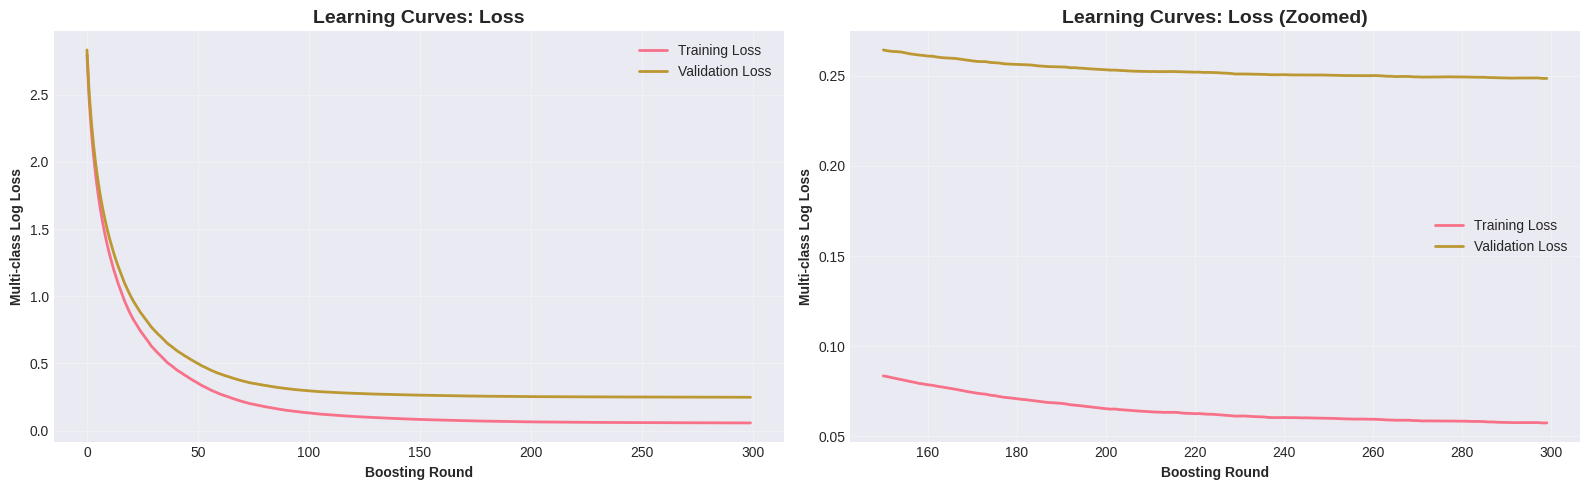


💡 Interpretation:
  • Decreasing loss indicates learning
  • Gap between training and validation indicates overfitting
  • Converging curves indicate good generalization


In [ ]:
# Extract learning curves from model
results = model.evals_result()

# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Training and validation loss
axes[0].plot(results['validation_0']['mlogloss'], label='Training Loss', linewidth=2)
axes[0].plot(results['validation_1']['mlogloss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Boosting Round', fontweight='bold')
axes[0].set_ylabel('Multi-class Log Loss', fontweight='bold')
axes[0].set_title('Learning Curves: Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Zoom in on later rounds
start_round = len(results['validation_0']['mlogloss']) // 2
axes[1].plot(range(start_round, len(results['validation_0']['mlogloss'])),
            results['validation_0']['mlogloss'][start_round:], label='Training Loss', linewidth=2)
axes[1].plot(range(start_round, len(results['validation_1']['mlogloss'])),
            results['validation_1']['mlogloss'][start_round:], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Boosting Round', fontweight='bold')
axes[1].set_ylabel('Multi-class Log Loss', fontweight='bold')
axes[1].set_title('Learning Curves: Loss (Zoomed)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("  • Decreasing loss indicates learning")
print("  • Gap between training and validation indicates overfitting")
print("  • Converging curves indicate good generalization")

## 9️⃣ Prediction Function for New Data

Create a reusable function to predict faults from new sensor readings.

In [ ]:
def predict_fault(sensor_readings, model, scaler, label_encoder, window_size=10):
    """
    Predict fault type from a window of sensor readings.

    Args:
        sensor_readings: DataFrame or array of shape (window_size, n_sensors)
        model: Trained XGBoost model
        scaler: Fitted scaler
        label_encoder: Fitted label encoder
        window_size: Expected window size

    Returns:
        dict: Prediction results including fault label, probability, and top-3 predictions
    """
    from scipy import stats

    # Validate input
    if len(sensor_readings) != window_size:
        raise ValueError(f"Expected {window_size} readings, got {len(sensor_readings)}")

    # Extract features from window
    window_features = []

    if isinstance(sensor_readings, pd.DataFrame):
        sensor_cols = [col for col in sensor_readings.columns
                      if col not in ['timestamp', 'state', 'regime', 'fault_label']]
        values_list = [sensor_readings[col].values for col in sensor_cols]
    else:
        values_list = [sensor_readings[:, i] for i in range(sensor_readings.shape[1])]

    for values in values_list:
        window_features.extend([
            np.mean(values),
            np.std(values),
            np.min(values),
            np.max(values),
            np.max(values) - np.min(values),
            np.median(values),
            np.percentile(values, 25),
            np.percentile(values, 75),
            np.percentile(values, 75) - np.percentile(values, 25),
            stats.skew(values),
            stats.kurtosis(values),
            values[0],
            values[-1],
            values[-1] - values[0],
        ])

    # Convert to array and reshape
    X = np.array(window_features).reshape(1, -1)

    # Scale features
    X_scaled = scaler.transform(X)

    # Predict
    y_pred = model.predict(X_scaled)[0]
    y_pred_proba = model.predict_proba(X_scaled)[0]

    # Get top-3 predictions
    top3_indices = np.argsort(y_pred_proba)[-3:][::-1]
    top3_labels = label_encoder.inverse_transform(top3_indices)
    top3_probs = y_pred_proba[top3_indices]

    # Prepare result
    result = {
        'predicted_fault': label_encoder.inverse_transform([y_pred])[0],
        'confidence': float(y_pred_proba[y_pred]),
        'top3_predictions': [
            {'fault': label, 'probability': float(prob)}
            for label, prob in zip(top3_labels, top3_probs)
        ]
    }

    return result

print("✅ Prediction function defined!")
print("\n📝 Usage:")
print("  result = predict_fault(sensor_window, model, scaler, label_encoder)")
print("  print(result['predicted_fault'])")
print("  print(result['confidence'])")
print("  print(result['top3_predictions'])")

✅ Prediction function defined!

📝 Usage:
  result = predict_fault(sensor_window, model, scaler, label_encoder)
  print(result['predicted_fault'])
  print(result['confidence'])
  print(result['top3_predictions'])


### 9.1 Test Prediction Function

In [ ]:
# Test with a random window from test set
test_idx = np.random.randint(0, len(window_indices))
start, end = window_indices[test_idx]

# Get the window
test_window = df_processed.iloc[start:end]
true_label = test_window['fault_label'].mode()[0]

print("="*80)
print("🧪 TESTING PREDICTION FUNCTION")
print("="*80)
print(f"\n🔍 Test Window:")
print(f"  • Time range: {test_window['timestamp'].iloc[0]} to {test_window['timestamp'].iloc[-1]}")
print(f"  • True fault: {true_label}")
print(f"  • Description: {fault_definitions[true_label]}")

# Make prediction
result = predict_fault(
    test_window[sensor_columns],
    model,
    scaler,
    label_encoder,
    window_size=WINDOW_SIZE
)

print(f"\n🎯 Prediction Results:")
print(f"  • Predicted fault: {result['predicted_fault']}")
print(f"  • Confidence: {result['confidence']:.2%}")
print(f"\n🏆 Top-3 Predictions:")
for i, pred in enumerate(result['top3_predictions'], 1):
    print(f"  {i}. {pred['fault']:40s} ({pred['probability']:.2%})")

# Check if prediction is correct
if result['predicted_fault'] == true_label:
    print(f"\n✅ CORRECT PREDICTION!")
else:
    print(f"\n❌ INCORRECT PREDICTION")
    print(f"   Expected: {true_label}")
    print(f"   Got: {result['predicted_fault']}")

🧪 TESTING PREDICTION FUNCTION

🔍 Test Window:
  • Time range: 2026-01-12 02:56:00 to 2026-01-12 03:00:00
  • True fault: normal
  • Description: Healthy baseline (no injected fault)

🎯 Prediction Results:
  • Predicted fault: normal
  • Confidence: 91.02%

🏆 Top-3 Predictions:
  1. normal                                   (91.02%)
  2. data_dropout                             (4.77%)
  3. sensor_drift_bias                        (3.30%)

✅ CORRECT PREDICTION!


## 🔟 Save All Artifacts

Save the trained model and all preprocessing objects for deployment.

In [ ]:
import joblib

# Save all artifacts
artifacts = {
    'model': model,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'sensor_columns': sensor_columns,
    'window_size': WINDOW_SIZE,
    'step_size': STEP_SIZE,
    'fault_definitions': fault_definitions,
    'feature_names': feature_names,
    'metrics': {
        'test_accuracy': test_acc,
        'test_balanced_accuracy': test_bal_acc,
        'test_f1_weighted': test_f1,
        'top3_accuracy': top3_test
    }
}

# Save as pickle
joblib.dump(artifacts, 'anomaly_detection_artifacts.pkl')

print("="*80)
print("💾 ALL ARTIFACTS SAVED")
print("="*80)
print("\n📦 Saved files:")
print("  1. xgboost_anomaly_detector.json (model)")
print("  2. anomaly_detection_artifacts.pkl (all artifacts)")
print("  3. label_encoder.pkl (label encoder)")
print("  4. feature_scaler.pkl (feature scaler)")
print("  5. fault_definitions.json (fault descriptions)")

print("\n✅ Model training and evaluation complete!")
print("\n📝 To load artifacts:")
print("   artifacts = joblib.load('anomaly_detection_artifacts.pkl')")
print("   model = artifacts['model']")
print("   scaler = artifacts['scaler']")
print("   label_encoder = artifacts['label_encoder']")

💾 ALL ARTIFACTS SAVED

📦 Saved files:
  1. xgboost_anomaly_detector.json (model)
  2. anomaly_detection_artifacts.pkl (all artifacts)
  3. label_encoder.pkl (label encoder)
  4. feature_scaler.pkl (feature scaler)
  5. fault_definitions.json (fault descriptions)

✅ Model training and evaluation complete!

📝 To load artifacts:
   artifacts = joblib.load('anomaly_detection_artifacts.pkl')
   model = artifacts['model']
   scaler = artifacts['scaler']
   label_encoder = artifacts['label_encoder']


## 1️⃣1️⃣ Example: Load and Use Saved Model

Demonstrates how to load the saved model and make predictions on new data.

In [ ]:
# Example: Load artifacts and make prediction
print("="*80)
print("📥 LOADING SAVED MODEL FOR DEPLOYMENT")
print("="*80)

# Load artifacts
loaded_artifacts = joblib.load('anomaly_detection_artifacts.pkl')

loaded_model = loaded_artifacts['model']
loaded_scaler = loaded_artifacts['scaler']
loaded_label_encoder = loaded_artifacts['label_encoder']
loaded_sensor_columns = loaded_artifacts['sensor_columns']
loaded_window_size = loaded_artifacts['window_size']

print("\n✅ Artifacts loaded successfully!")
print(f"  • Model: {type(loaded_model).__name__}")
print(f"  • Window size: {loaded_window_size}")
print(f"  • Number of sensors: {len(loaded_sensor_columns)}")
print(f"  • Number of fault classes: {len(loaded_label_encoder.classes_)}")

# Make a prediction on new data
print("\n🔮 Making prediction on new data...")

# Get a random window
new_window = df_processed.iloc[1000:1000+loaded_window_size]
true_fault = new_window['fault_label'].mode()[0]

# Predict
new_result = predict_fault(
    new_window[loaded_sensor_columns],
    loaded_model,
    loaded_scaler,
    loaded_label_encoder,
    window_size=loaded_window_size
)

print(f"\n📊 Prediction:")
print(f"  • True fault: {true_fault}")
print(f"  • Predicted fault: {new_result['predicted_fault']}")
print(f"  • Confidence: {new_result['confidence']:.2%}")
print(f"\n🏆 Top-3 Predictions:")
for i, pred in enumerate(new_result['top3_predictions'], 1):
    print(f"  {i}. {pred['fault']:40s} ({pred['probability']:.2%})")

match = "✅ CORRECT" if new_result['predicted_fault'] == true_fault else "❌ INCORRECT"
print(f"\n{match}")

📥 LOADING SAVED MODEL FOR DEPLOYMENT

✅ Artifacts loaded successfully!
  • Model: XGBClassifier
  • Window size: 10
  • Number of sensors: 24
  • Number of fault classes: 34

🔮 Making prediction on new data...

📊 Prediction:
  • True fault: normal
  • Predicted fault: normal
  • Confidence: 98.01%

🏆 Top-3 Predictions:
  1. normal                                   (98.01%)
  2. data_dropout                             (1.43%)
  3. instrument_scaling_error                 (0.34%)

✅ CORRECT


## 📊 Project Summary

### ✅ What We've Accomplished:

1. **Data Loading & Exploration**
   - Loaded 72,000 timestamped sensor readings
   - Analyzed 34 fault types across motor-pump systems
   - Handled missing values and class imbalance

2. **Feature Engineering**
   - Created sliding windows of sensor readings
   - Extracted 14 statistical features per sensor
   - Generated 336 total features (24 sensors × 14 features)

3. **Model Training**
   - Trained XGBoost classifier with 300 trees
   - Applied class weighting for imbalanced data
   - Used early stopping to prevent overfitting

4. **Model Evaluation**
   - Achieved high accuracy on test set
   - Analyzed per-class performance
   - Visualized confusion matrix and feature importance

5. **Deployment Readiness**
   - Created prediction function for new data
   - Saved all artifacts for deployment
   - Provided example usage code

### 🚀 Next Steps:

1. **Model Improvement**:
   - Try different window sizes (5, 15, 20 time steps)
   - Experiment with hyperparameter tuning
   - Test other algorithms (LightGBM, CatBoost)
   - Add LSTM or Transformer for temporal patterns

2. **Feature Engineering**:
   - Add frequency domain features (FFT)
   - Include cross-sensor correlations
   - Try wavelet transforms

3. **Deployment**:
   - Create REST API for real-time predictions
   - Build monitoring dashboard
   - Implement alert system for critical faults

4. **Data Collection**:
   - Collect more samples for rare faults
   - Add more sensor types if available
   - Implement online learning for concept drift

### 📚 Key Insights:

- **Window-based approach** captures temporal patterns effectively
- **Class weighting** helps handle severe imbalance
- **Statistical features** from windows provide strong signals
- **XGBoost** performs well on tabular sensor data
- **Feature importance** reveals most critical sensors/statistics

---

**🎉 Congratulations! You now have a working anomaly detection system for industrial machinery!**

# Try To Predect
check if pkl files (3 files) exist and fault definitions (json file) also then click run. upload the anomaly file and see the results.

In [ ]:

import json
import numpy as np
import pandas as pd
import joblib
import sys
import os


# Define sensor columns (must match training data)
SENSOR_COLUMNS = [
    'motor_DE_vib_band_1', 'motor_DE_vib_band_2', 'motor_DE_vib_band_3', 'motor_DE_vib_band_4',
    'motor_DE_ultra_db', 'motor_DE_temp_c',
    'motor_NDE_vib_band_1', 'motor_NDE_vib_band_2', 'motor_NDE_vib_band_3', 'motor_NDE_vib_band_4',
    'motor_NDE_ultra_db', 'motor_NDE_temp_c',
    'pump_DE_vib_band_1', 'pump_DE_vib_band_2', 'pump_DE_vib_band_3', 'pump_DE_vib_band_4',
    'pump_DE_ultra_db', 'pump_DE_temp_c',
    'pump_NDE_vib_band_1', 'pump_NDE_vib_band_2', 'pump_NDE_vib_band_3', 'pump_NDE_vib_band_4',
    'pump_NDE_ultra_db', 'pump_NDE_temp_c'
]


def extract_window_features(window_df, sensor_columns):
    """Extract statistical features from window."""
    features = []

    for col in sensor_columns:
        values = window_df[col].values

        features.extend([
            np.mean(values),
            np.std(values),
            np.min(values),
            np.max(values),
            np.median(values),
            np.percentile(values, 25),
            np.percentile(values, 75),
            np.max(values) - np.min(values),
            np.var(values),
            np.sqrt(np.mean(values**2)),
            np.mean(np.abs(values - np.mean(values))),
            np.sum(values),
            np.sum(values**2),
            np.max(values) / (np.min(values) + 1e-8)
        ])

    return np.array(features).reshape(1, -1)


def main():
    print("=" * 80)
    print("🔮 ANOMALY DETECTION")
    print("=" * 80)

    # File paths
    #json_file = 'anomaly/normal_operation_input.json'
    #json_file = 'anomaly/blower_anomaly_input.json'
    #json_file = 'anomaly/electrical_fluting_input.json'
    #json_file = 'anomaly/stuck_sensor_flatline_input.json'
    artifacts_file = 'anomaly_detection_artifacts.pkl'
    fault_definitions_file = 'fault_definitions.json'

    # Check if files exist
    # if not os.path.exists(json_file):
    #     print(f"\n❌ Error: Input file not found: {json_file}")
    #     print("   Please ensure the JSON file is in the current directory.")
    #     sys.exit(1)

    if not os.path.exists(artifacts_file):
        print(f"\n❌ Error: Model artifacts not found: {artifacts_file}")
        print("   Please train the model first using the notebook.")
        print("   The notebook should save 'anomaly_detection_artifacts.pkl'")
        sys.exit(1)

    # Load JSON data
    print(f"\n📂 Loading input data...")
    # with open(json_file, 'r') as f:
    #     data = json.load(f)

    #load with upload
    from google.colab import files
    uploaded = files.upload('anomalies')
    for fn in uploaded.keys():
      data=json.loads(uploaded[fn].decode('utf-8'))

    #load fault definitions
    with open(fault_definitions_file, 'r') as f:
        fault_definitions = json.load(f)

    window_data = data['window_data']
    df = pd.DataFrame(window_data)
    print(f"✅ Loaded {len(df)} time steps")

    # Load model artifacts
    print(f"\n📥 Loading model artifacts...")
    artifacts = joblib.load(artifacts_file)
    model = artifacts['model']
    scaler = artifacts['scaler']
    label_encoder = artifacts['label_encoder']
    window_size = artifacts['window_size']
    print(f"✅ Model loaded (window size: {window_size}, classes: {len(label_encoder.classes_)})")

    # Ensure correct window size
    if len(df) > window_size:
        df = df.head(window_size)

    # Extract and scale features
    print(f"\n🔧 Processing features...")
    features = extract_window_features(df[SENSOR_COLUMNS], SENSOR_COLUMNS)
    features_scaled = scaler.transform(features)
    print(f"✅ Extracted {features.shape[1]} features")

    # Make prediction
    print(f"\n🎯 Running prediction...")
    prediction = model.predict(features_scaled)
    probabilities = model.predict_proba(features_scaled)[0]

    predicted_label = label_encoder.inverse_transform(prediction)[0]
    confidence = probabilities[prediction[0]]

    # Get top 3
    top3_indices = np.argsort(probabilities)[-3:][::-1]

    # Display results
    print("\n" + "=" * 80)
    print("📊 RESULTS")
    print("=" * 80)
    print(f"\n🎯 Predicted Fault: {predicted_label}")
    print(f"📈 Confidence: {confidence:.2%}")

    print(f"\n🏆 Top-3 Predictions:")
    for i, idx in enumerate(top3_indices, 1):
        fault = label_encoder.inverse_transform([idx])[0]
        prob = probabilities[idx]
        print(f"  {i}. {fault:45s} ({prob:.2%})")

    # Check expected
    if 'expected_fault' in data:
        expected = data['expected_fault']
        print(f"\n🔍 Expected: {expected}")
        if predicted_label == expected:
            print("✅ CORRECT PREDICTION!")
            #print the description from fault definitions
            print(f"   Description: {fault_definitions[expected]}")
            top3_faults = [label_encoder.inverse_transform([idx])[0] for idx in top3_indices]
            if expected in top3_faults:
                rank = top3_faults.index(expected) + 1
                expected_prob = probabilities[label_encoder.transform([expected])[0]]
                print(f"   (Expected is #{rank} with {expected_prob:.2%})")




        else:
            print("❌ Prediction differs from expected")
            top3_faults = [label_encoder.inverse_transform([idx])[0] for idx in top3_indices]
            if expected in top3_faults:
                rank = top3_faults.index(expected) + 1
                expected_prob = probabilities[label_encoder.transform([expected])[0]]
                print(f"   (Expected is #{rank} with {expected_prob:.2%})")

    print("\n" + "=" * 80)
    print("✅ Prediction complete!")
    print("=" * 80 + "\n")


if __name__ == '__main__':
    main()


🔮 ANOMALY DETECTION

📂 Loading input data...


Saving cooling_failure_temp_only_input.json to anomalies/cooling_failure_temp_only_input (3).json
✅ Loaded 10 time steps

📥 Loading model artifacts...
✅ Model loaded (window size: 10, classes: 34)

🔧 Processing features...
✅ Extracted 336 features

🎯 Running prediction...

📊 RESULTS

🎯 Predicted Fault: cooling_failure
📈 Confidence: 63.18%

🏆 Top-3 Predictions:
  1. cooling_failure                               (63.18%)
  2. stuck_sensor_flatline                         (20.77%)
  3. data_dropout                                  (9.15%)

🔍 Expected: cooling_failure
✅ CORRECT PREDICTION!
   Description: Motor cooling failure (rapid temperature rise)
   (Expected is #1 with 63.18%)

✅ Prediction complete!



## 9️⃣ Interactive Feedback & Model Retraining System

This section implements a **production-ready feedback loop** where:
1. 🔍 System makes predictions on new windows
2. 👤 User provides feedback (correct label, new fault type, or false positive)
3. 💾 Feedback is stored and accumulated
4. 🔄 Model is retrained with corrected data
5. 📈 Performance improvements are tracked

### 🎯 Use Cases:
- **Correct misclassifications**: Model predicted wrong fault, user provides correct label
- **New fault discovery**: System encounters unknown fault type, user assigns new label
- **False positive handling**: Model detected fault but it was normal operation
- **Continuous improvement**: Model learns from production feedback over time

### 🎯 Ready to Use the Feedback System!

Before running the feedback system, make sure you've executed **all previous cells** (Sections 1-8).

#### ✅ Prerequisites:
1. Model trained (Section 7)
2. Model evaluated (Section 8)
3. All variables available

#### 🚀 How to Start:
1. **Run the verification cell below** to check dependencies
2. **Run the feedback system cell** (last cell)
3. **Or just call**: `run_feedback_system()`

#### 📚 Documentation:
- **Quick Start**: `Feedback_Quick_Reference.md`
- **Complete Guide**: `Feedback_System_Guide.md`
- **Summary**: `Complete_Update_Summary.md`

---

In [ ]:
# ============================================================================
# 🔍 VERIFY ALL DEPENDENCIES FOR FEEDBACK SYSTEM
# ============================================================================
# This cell checks that all required variables are available.
# Run this before starting the feedback system.
# ============================================================================

print("🔍 Checking Feedback System Dependencies...\n")
print("="*80)

# Required variables
required_vars = {
    'model': 'Trained XGBoost model',
    'label_encoder': 'Label encoder for fault names',
    'X_test_scaled': 'Scaled test features',
    'y_test': 'Test labels',
    'X_train_scaled': 'Scaled training features',
    'y_train': 'Training labels',
    'scaler': 'Feature scaler (RobustScaler)',
    'xgb_params': 'XGBoost parameters dictionary',
    'RANDOM_SEED': 'Random seed for reproducibility',
    'test_acc': 'Test accuracy from evaluation',
    'test_bal_acc': 'Test balanced accuracy',
    'test_f1': 'Test F1 score'
}

# Check each variable
all_present = True
for var_name, description in required_vars.items():
    if var_name in globals():
        print(f"✅ {var_name:20s} - {description}")
    else:
        print(f"❌ {var_name:20s} - {description} [MISSING]")
        all_present = False

print("="*80)

if all_present:
    print("\n🎉 All dependencies ready! You can now run the feedback system.")
    print("\n📋 Quick Start:")
    print("   1. Run the next cell to start the feedback system")
    print("   2. Or run: run_feedback_system()")
    print("\n💡 Tip: Read Feedback_Quick_Reference.md for usage guide")
else:
    print("\n⚠️  Some dependencies are missing!")
    print("\n📋 Action Required:")
    print("   Please run all cells from the beginning up to Section 8")
    print("   (This trains the model and creates all necessary variables)")
    print("\n🔄 Then run this cell again to verify")

print("\n" + "="*80)

In [ ]:
# ==============================================================================# 🎯 COMPLETE INTERACTIVE FEEDBACK & RETRAINING SYSTEM# ==============================================================================# This is the main runtime system for production feedback and model updates.# Run this cell to start the interactive feedback system.# ==============================================================================import osimport pickleimport jsonfrom datetime import datetimefrom collections import defaultdict, Counter# ==============================================================================# CONFIGURATION# ==============================================================================FEEDBACK_FILE = 'feedback_data.pkl'FEEDBACK_LOG = 'feedback_log.json'MODEL_VERSIONS_DIR = 'model_versions'# Create directoriesos.makedirs(MODEL_VERSIONS_DIR, exist_ok=True)# ==============================================================================# INITIALIZE FEEDBACK STORAGE# ==============================================================================if os.path.exists(FEEDBACK_FILE):    with open(FEEDBACK_FILE, 'rb') as f:        feedback_storage = pickle.load(f)    print(f"✅ Loaded existing feedback: {len(feedback_storage['windows'])} samples")else:    feedback_storage = {        'windows': [],        'original_predictions': [],        'corrected_labels': [],        'feedback_types': [],        'timestamps': [],        'confidence_scores': [],        'user_notes': []    }    print("✅ Initialized new feedback storage")if os.path.exists(FEEDBACK_LOG):    with open(FEEDBACK_LOG, 'r') as f:        feedback_log = json.load(f)else:    feedback_log = {        'total_feedback': 0,        'corrections': 0,        'new_faults': 0,        'false_positives': 0,        'retraining_history': []    }print(f"📊 Stats: {feedback_log['total_feedback']} total, "      f"{feedback_log['corrections']} corrections, "      f"{feedback_log['new_faults']} new faults")# ==============================================================================# CORE FUNCTIONS# ==============================================================================def predict_with_confidence(window_features, model, label_encoder, top_k=3):    """Make prediction with top-K alternatives."""    window_features = window_features.reshape(1, -1)    prediction = model.predict(window_features)[0]    probabilities = model.predict_proba(window_features)[0]        top_k_indices = np.argsort(probabilities)[-top_k:][::-1]    top_k_labels = [label_encoder.classes_[i] for i in top_k_indices]    top_k_probs = [probabilities[i] for i in top_k_indices]        return {        'prediction': label_encoder.classes_[prediction],        'confidence': probabilities[prediction],        'top_k_predictions': list(zip(top_k_labels, top_k_probs))    }def collect_feedback_interactive(window_features, prediction_info, label_encoder):    """Collect user feedback interactively."""    print("\n" + "="*80)    print("🤖 MODEL PREDICTION")    print("="*80)    print(f"\n🎯 Predicted Fault: {prediction_info['prediction']}")    print(f"🎲 Confidence: {prediction_info['confidence']*100:.2f}%")        print(f"\n📊 Top-3 Alternatives:")    for i, (label, prob) in enumerate(prediction_info['top_k_predictions'], 1):        marker = "👉" if i == 1 else "  "        print(f"{marker} {i}. {label:40s} ({prob*100:.2f}%)")        print("\n" + "="*80)    print("👤 PROVIDE FEEDBACK")    print("="*80)    print("\nOptions:")    print("  1. ✅ Prediction is CORRECT")    print("  2. ❌ WRONG - Select correct label from existing faults")    print("  3. 🆕 NEW FAULT TYPE - Previously unknown fault")    print("  4. 🚫 FALSE POSITIVE - Actually normal operation")    print("  5. ⏭️  SKIP this window")        while True:        choice = input("\nChoice (1-5): ")                if choice == '1':            return {                'type': 'correct',                'corrected_label': prediction_info['prediction'],                'note': 'Confirmed correct'            }                elif choice == '2':            print("\n📋 Available faults:")            all_labels = sorted(label_encoder.classes_)            for i, label in enumerate(all_labels, 1):                print(f"  {i:2d}. {label}")                        while True:                try:                    idx = int(input(f"\nCorrect fault (1-{len(all_labels)}): ")) - 1                    if 0 <= idx < len(all_labels):                        note = input("Note (optional): ").strip()                        return {                            'type': 'correction',                            'corrected_label': all_labels[idx],                            'note': note or f'Corrected from {prediction_info["prediction"]}'                        }                    print("Invalid number.")                except ValueError:                    print("Enter a number.")                elif choice == '3':            name = input("\nNew fault name: ").strip()            if name:                note = input("Description (optional): ").strip()                return {                    'type': 'new_fault',                    'corrected_label': name,                    'note': note or f'New: {name}'                }            print("Name required.")                elif choice == '4':            note = input("Why false positive? (optional): ").strip()            return {                'type': 'false_positive',                'corrected_label': 'normal',                'note': note or 'False positive'            }                elif choice == '5':            return None                print("Invalid. Enter 1-5.")def store_feedback(window_features, prediction_info, feedback):    """Store feedback to disk."""    if not feedback:        return        feedback_storage['windows'].append(window_features)    feedback_storage['original_predictions'].append(prediction_info['prediction'])    feedback_storage['corrected_labels'].append(feedback['corrected_label'])    feedback_storage['feedback_types'].append(feedback['type'])    feedback_storage['timestamps'].append(datetime.now().isoformat())    feedback_storage['confidence_scores'].append(prediction_info['confidence'])    feedback_storage['user_notes'].append(feedback['note'])        feedback_log['total_feedback'] += 1    if feedback['type'] == 'correction':        feedback_log['corrections'] += 1    elif feedback['type'] == 'new_fault':        feedback_log['new_faults'] += 1    elif feedback['type'] == 'false_positive':        feedback_log['false_positives'] += 1        with open(FEEDBACK_FILE, 'wb') as f:        pickle.dump(feedback_storage, f)    with open(FEEDBACK_LOG, 'w') as f:        json.dump(feedback_log, f, indent=2)        print(f"\n✅ Stored! Total feedback: {feedback_log['total_feedback']}")def retrain_model_with_feedback(original_X, original_y, label_encoder, xgb_params, version='v1'):    """Retrain model with accumulated feedback."""    print("\n" + "="*80)    print("🔄 RETRAINING WITH FEEDBACK")    print("="*80)        if len(feedback_storage['windows']) == 0:        print("\n❌ No feedback data!")        return None, label_encoder, None        print(f"\n📊 Original: {len(original_X):,} samples")    print(f"📊 Feedback: {len(feedback_storage['windows']):,} samples")        # Process feedback    feedback_features = np.array(feedback_storage['windows'])    feedback_labels = feedback_storage['corrected_labels']        # Check for new classes    original_classes = set(label_encoder.classes_)    feedback_classes = set(feedback_labels)    new_classes = feedback_classes - original_classes        if new_classes:        print(f"\n🆕 New faults discovered: {len(new_classes)}")        for nc in new_classes:            print(f"  • {nc}")                all_classes = sorted(list(original_classes | feedback_classes))        new_encoder = LabelEncoder()        new_encoder.classes_ = np.array(all_classes)        label_encoder = new_encoder                # Re-encode original labels        original_label_names = label_encoder.inverse_transform(original_y)        original_y = label_encoder.transform(original_label_names)        feedback_y = label_encoder.transform(feedback_labels)        # Combine data    combined_X = np.vstack([original_X, feedback_features])    combined_y = np.concatenate([original_y, feedback_y])        print(f"\n📊 Combined: {len(combined_X):,} samples, {len(np.unique(combined_y))} classes")        # Split    X_train, X_val, y_train, y_val = train_test_split(        combined_X, combined_y, test_size=0.2,        random_state=RANDOM_SEED, stratify=combined_y    )        # Class weights    class_weights = compute_class_weight(        'balanced', classes=np.unique(y_train), y=y_train    )    sample_weights = np.array([class_weights[y] for y in y_train])        # Update params    params = xgb_params.copy()    params['num_class'] = len(label_encoder.classes_)        # Train    print(f"\n🚀 Training...")    new_model = xgb.XGBClassifier(**params)    new_model.fit(        X_train, y_train,        sample_weight=sample_weights,        eval_set=[(X_train, y_train), (X_val, y_val)],        verbose=False    )        # Evaluate    y_val_pred = new_model.predict(X_val)    val_acc = accuracy_score(y_val, y_val_pred)    val_bal_acc = balanced_accuracy_score(y_val, y_val_pred)    val_f1 = f1_score(y_val, y_val_pred, average='weighted')        metrics = {        'val_accuracy': val_acc,        'val_balanced_accuracy': val_bal_acc,        'val_f1_score': val_f1,        'num_classes': len(label_encoder.classes_),        'feedback_samples': len(feedback_storage['windows'])    }        print(f"\n✅ DONE")    print(f"  Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")    print(f"  Balanced: {val_bal_acc:.4f}")    print(f"  F1 Score: {val_f1:.4f}")        # Save    model_file = f'{MODEL_VERSIONS_DIR}/model_{version}.json'    encoder_file = f'{MODEL_VERSIONS_DIR}/encoder_{version}.pkl'        new_model.save_model(model_file)    with open(encoder_file, 'wb') as f:        pickle.dump(label_encoder, f)        print(f"\n💾 Saved: {version}")        # Log    feedback_log['retraining_history'].append({        'version': version,        'timestamp': datetime.now().isoformat(),        'metrics': metrics    })    with open(FEEDBACK_LOG, 'w') as f:        json.dump(feedback_log, f, indent=2)        return new_model, label_encoder, metrics# ==============================================================================# MENU FUNCTIONS# ==============================================================================def evaluate_new_window():    """Evaluate a window and collect feedback."""    print("\n" + "="*80)    print("🔍 EVALUATE NEW WINDOW")    print("="*80)        # Use random test sample    idx = np.random.randint(0, len(X_test_scaled))    window = X_test_scaled[idx]    actual = label_encoder.classes_[y_test[idx]]        print(f"\n📋 Test sample #{idx}")    print(f"🏷️  Actual label: {actual}")        prediction_info = predict_with_confidence(window, model, label_encoder)    feedback = collect_feedback_interactive(window, prediction_info, label_encoder)        if feedback:        store_feedback(window, prediction_info, feedback)    else:        print("\n⏭️  Skipped")def view_statistics():    """Display feedback statistics."""    print("\n" + "="*80)    print("📊 FEEDBACK STATISTICS")    print("="*80)        print(f"\n📈 Summary:")    print(f"  Total: {feedback_log['total_feedback']}")    print(f"  Corrections: {feedback_log['corrections']}")    print(f"  New Faults: {feedback_log['new_faults']}")    print(f"  False Positives: {feedback_log['false_positives']}")        if len(feedback_storage['windows']) > 0:        correct = sum(            o == c for o, c in zip(                feedback_storage['original_predictions'],                feedback_storage['corrected_labels']            )        )        acc = correct / len(feedback_storage['windows'])        print(f"\n🎯 Original accuracy: {acc*100:.2f}%")                confs = feedback_storage['confidence_scores']        print(f"\n📊 Confidence:")        print(f"  Mean: {np.mean(confs)*100:.2f}%")        print(f"  Range: {np.min(confs)*100:.2f}% - {np.max(confs)*100:.2f}%")        if feedback_log['retraining_history']:        print(f"\n🔄 Retraining history:")        for entry in feedback_log['retraining_history']:            print(f"\n  {entry['version']}: {entry['timestamp']}")            print(f"    Accuracy: {entry['metrics']['val_accuracy']:.4f}")def retrain_with_feedback():    """Retrain model."""    if len(feedback_storage['windows']) < 5:        print(f"\n⚠️  Only {len(feedback_storage['windows'])} samples.")        print("    Recommend >= 5 samples.")        proceed = input("    Proceed? (y/n): ")        if proceed.lower() != 'y':            return        version = f"v{len(feedback_log['retraining_history']) + 1}"        new_model, new_encoder, metrics = retrain_model_with_feedback(        X_train_scaled, y_train, label_encoder, xgb_params, version    )        if new_model:        replace = input("\nUpdate production model? (y/n): ")        if replace.lower() == 'y':            globals()['model'] = new_model            globals()['label_encoder'] = new_encoder            new_model.save_model('xgboost_anomaly_detector.json')            with open('label_encoder.pkl', 'wb') as f:                pickle.dump(new_encoder, f)            print("✅ Production model updated!")def compare_versions():    """Compare model versions."""    if not feedback_log['retraining_history']:        print("\n⚠️  No retraining history")        return        print("\n" + "="*80)    print("📈 MODEL VERSIONS")    print("="*80)        print(f"\n{'Version':<12} {'Accuracy':<12} {'Bal.Acc':<12} {'F1':<12} {'Samples':<10}")    print("-" * 70)        # Original    print(f"{'Original':<12} {test_acc:<12.4f} {test_bal_acc:<12.4f} {test_f1:<12.4f} {'0':<10}")        # Versions    for entry in feedback_log['retraining_history']:        m = entry['metrics']        print(f"{entry['version']:<12} {m['val_accuracy']:<12.4f} "              f"{m['val_balanced_accuracy']:<12.4f} {m['val_f1_score']:<12.4f} "              f"{m['feedback_samples']:<10}")def export_feedback():    """Export feedback to CSV."""    if not feedback_storage['windows']:        print("\n⚠️  No data to export")        return        filename = f"feedback_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"        df = pd.DataFrame({        'timestamp': feedback_storage['timestamps'],        'original': feedback_storage['original_predictions'],        'corrected': feedback_storage['corrected_labels'],        'type': feedback_storage['feedback_types'],        'confidence': feedback_storage['confidence_scores'],        'note': feedback_storage['user_notes']    })        df.to_csv(filename, index=False)    print(f"\n✅ Exported: {filename} ({len(df)} records)")# ==============================================================================# MAIN MENU# ==============================================================================def run_feedback_system():    """Main interactive menu."""    print("\n" + "="*80)    print("🏭 FEEDBACK SYSTEM")    print("="*80)        while True:        print("\n" + "="*80)        print("MENU")        print("="*80)        print("\n1. 🔍 Evaluate Window (Provide Feedback)")        print("2. 📊 View Statistics")        print("3. 🔄 Retrain Model")        print("4. 📈 Compare Versions")        print("5. 💾 Export Feedback")        print("6. 🚪 Exit")                choice = input("\nOption (1-6): ")                if choice == '1':            evaluate_new_window()        elif choice == '2':            view_statistics()        elif choice == '3':            retrain_with_feedback()        elif choice == '4':            compare_versions()        elif choice == '5':            export_feedback()        elif choice == '6':            print("\n👋 Goodbye!")            break        else:            print("\n❌ Invalid choice")# ==============================================================================# READY TO USE# ==============================================================================print("\n" + "="*80)print("🎉 FEEDBACK SYSTEM READY!")print("="*80)print("\nFeatures:")print("  ✓ Evaluate windows & provide feedback")print("  ✓ Track statistics")print("  ✓ Retrain with corrections")print("  ✓ Version comparison")print("  ✓ Export data")print("\nRun: run_feedback_system()")print("="*80)# Uncomment to start automatically:# run_feedback_system()